## Imports

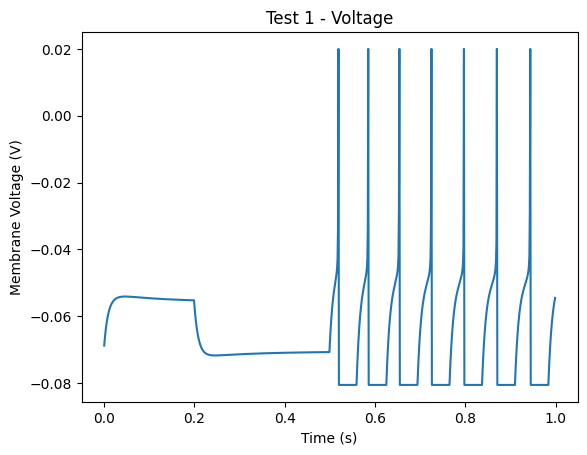

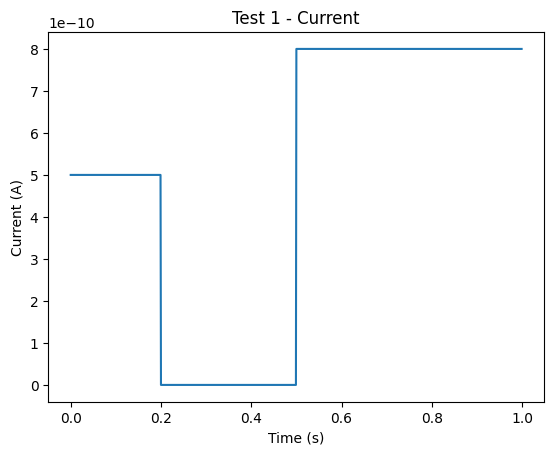

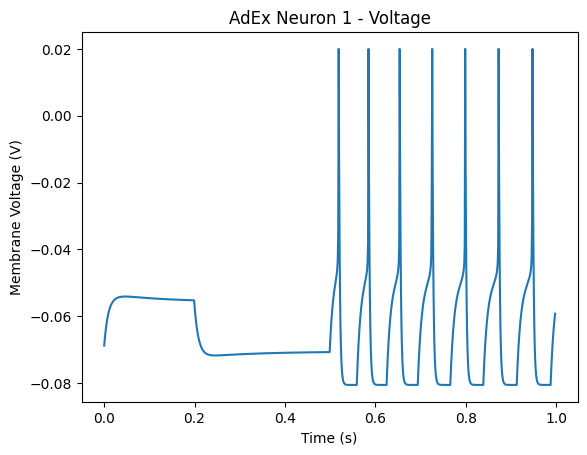

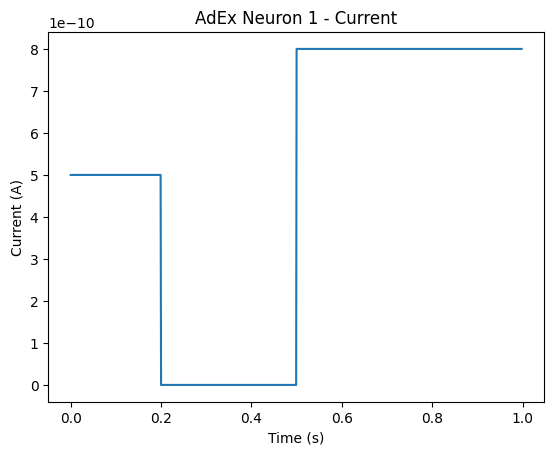

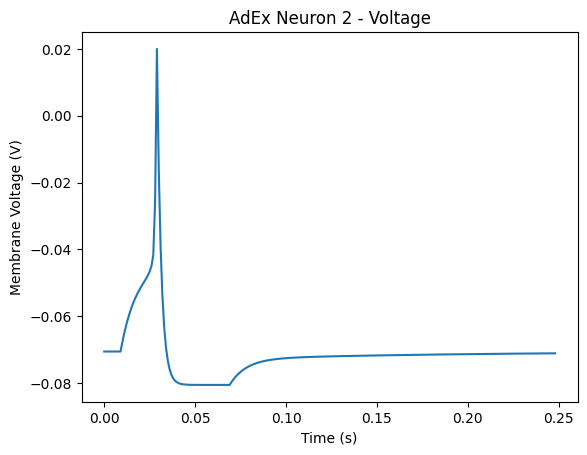

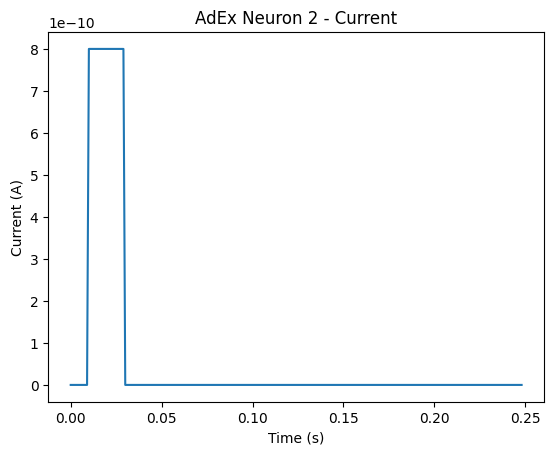

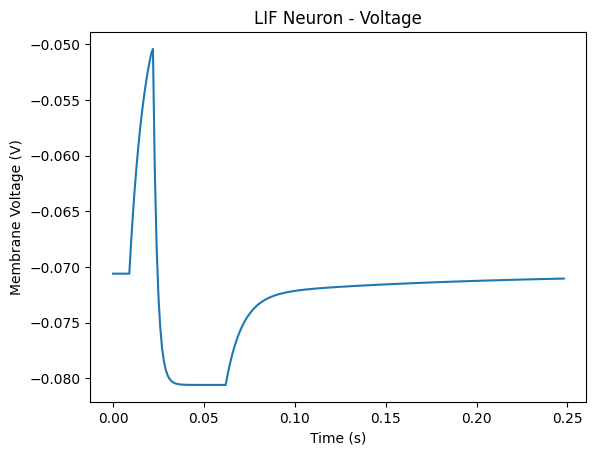

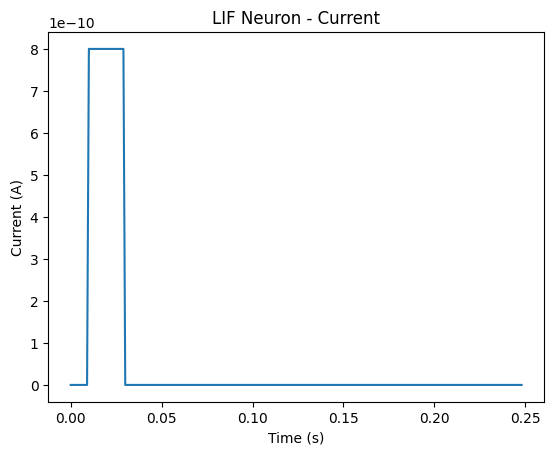

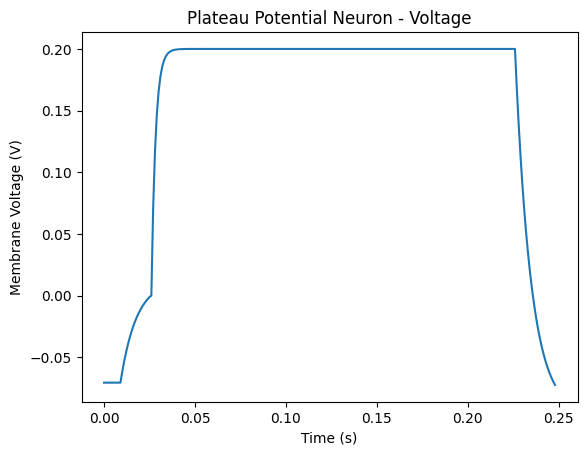

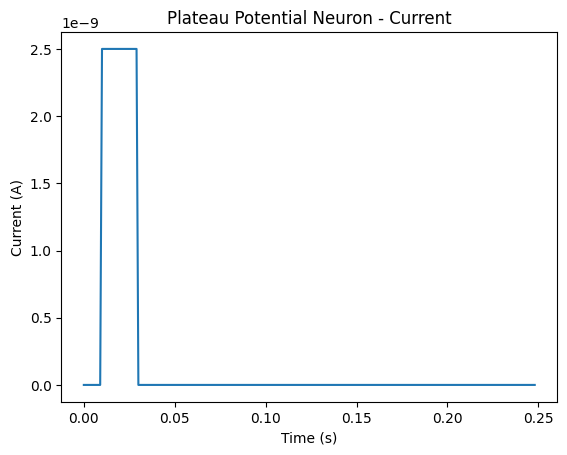

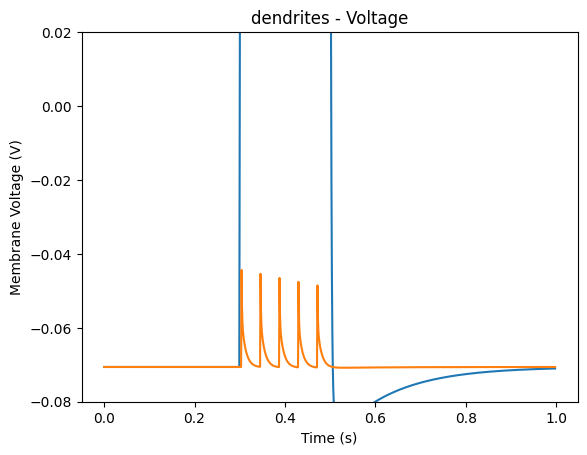

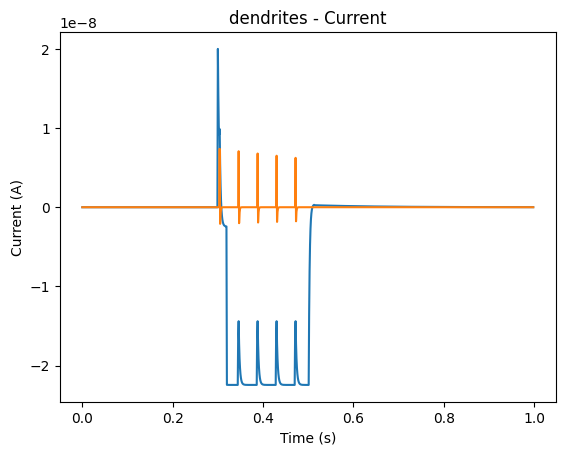

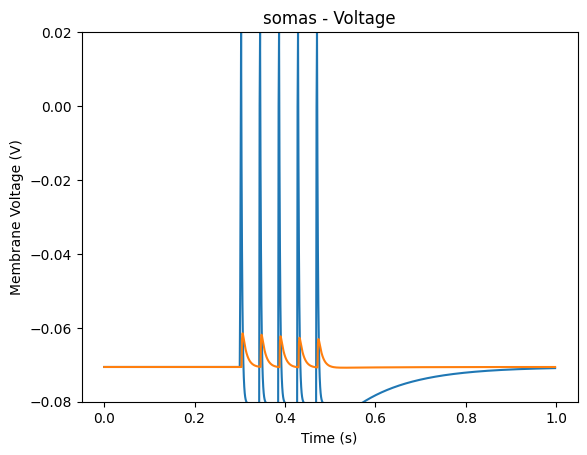

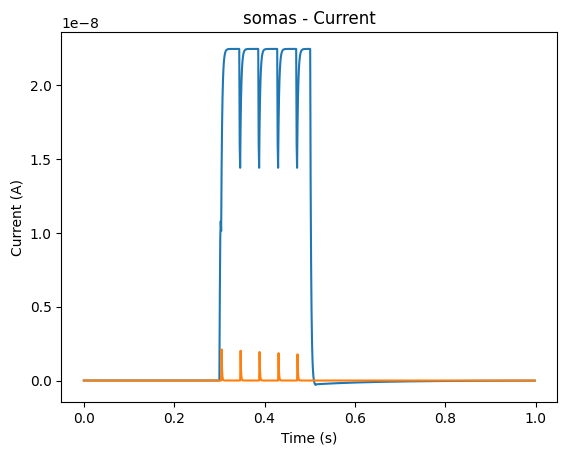

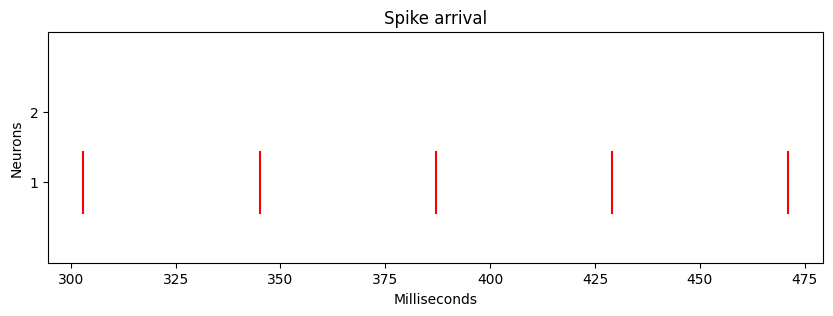

In [1]:
from ipynb.fs.full.BSS2Lava import *
from ipynb.fs.full.BSS2Neurons import *

## Passive Chains

Here, we set up a chain of four passive compartments, connected to each other at a fixed conductance. A triangle spike is applied to one of the compartments (at index injection_site), and it propagates to the others. Multiple chains are graphed, where each chain has a different conductance between elements. This is designed to imitate figure 4A in the BSS-2 paper.

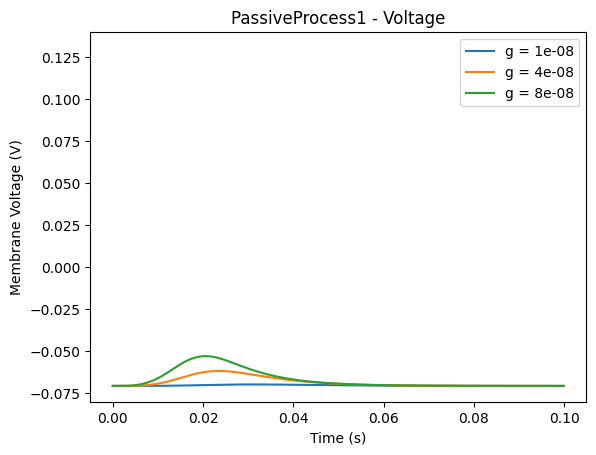

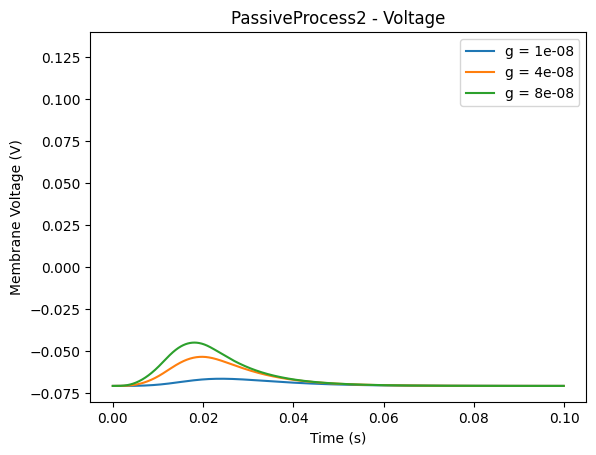

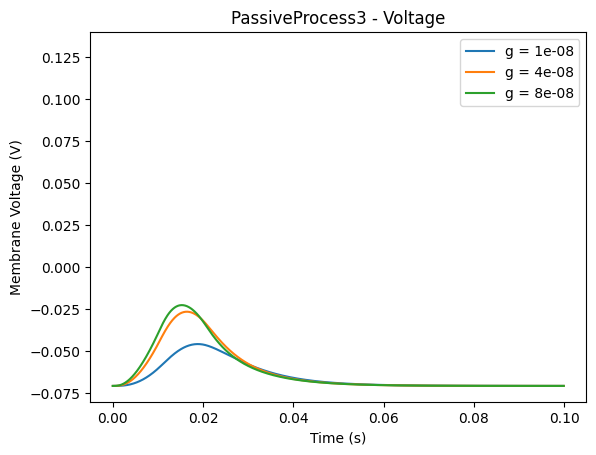

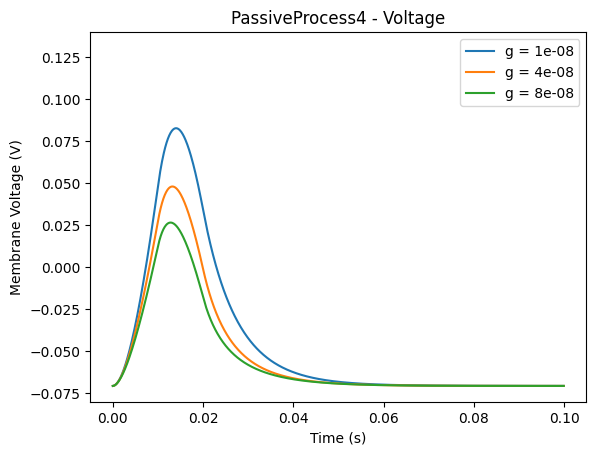

In [2]:
total_time = 0.1
dt = 0.0001

num_passives = 4

assert num_passives > 0, "need at least one neuron!"

injection_site = 3

assert injection_site >= 0 and injection_site < num_passives, "one of the passives must receive injection!"

names = [f'PassiveProcess{i + 1}' for i in range(num_passives)]
num_neurons = 3
shape = (num_neurons,)
model_tag = None

num_steps = (int)(total_time // dt)

gs = np.array([1e-8, 4e-8, 8e-8])
legend = [f'g = {g}' for g in gs]

processes = []
for i in range(num_passives):
    if i == injection_site:
        processes.append(BSSNeuronProcessTriangleSpike(name=names[i], dt=dt, shape=shape,
                            physical_properties=Passive,
                            heights = 0.1e-7, 
                            starts = 0,
                            uptimes = 0.01,
                            downtimes = 0.01))
    else:
        processes.append(BSSNeuronProcess(name=names[i], dt=dt, shape=shape, physical_properties=Passive))
    if i > 0:
        connect_neurons(processes[i], processes[i - 1], Direction.LEFT, gs)

monitors = [StandardNeuronMonitors(process, num_steps) for process in processes]

run_cfg = Loihi1SimCfg(select_tag=model_tag)
processes[0].run(condition=RunSteps(num_steps=num_steps), run_cfg=run_cfg)

for n in range(num_passives):
    plot_voltage(names[n], [i * dt for i in range(num_steps)], 
                             monitors[n].V_m_monitor.get_neuron_data(), 
                             legend=legend,
                             min_axis = -80e-3, max_axis=140e-3)

# for n in range(num_passives):
#     plot_current(names[n], [i * dt for i in range(num_steps)], 
#                              monitors[n].I_monitor.get_neuron_data(),
#                              legend=legend)

processes[0].stop()

## Two-compartment model

This is designed to imitate the system in figure 3A of the BSS-2 paper, which describes a two-compartment model of a passive compartment and a "soma" with sodium spike dynamics, which are represented with AdEx. I'm feeding a short spike into the passive compartment, and the sodium compartment spikes accordingly.

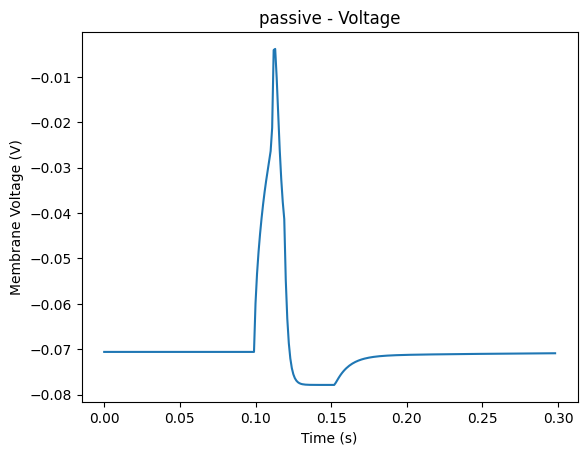

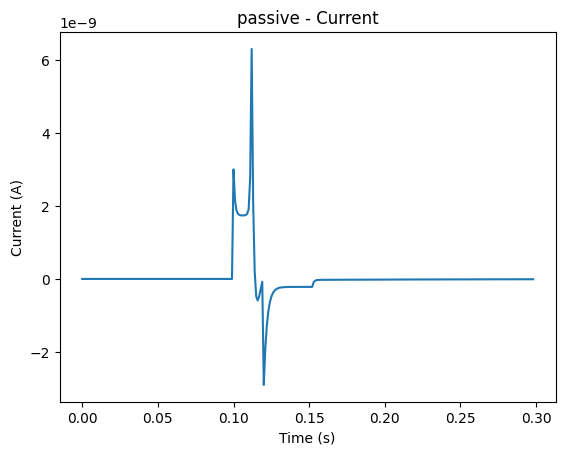

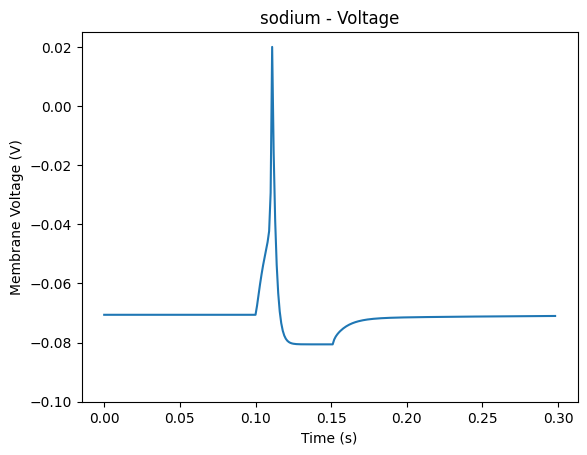

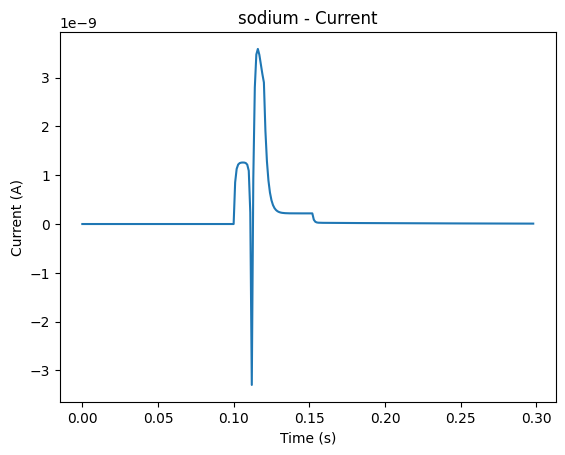

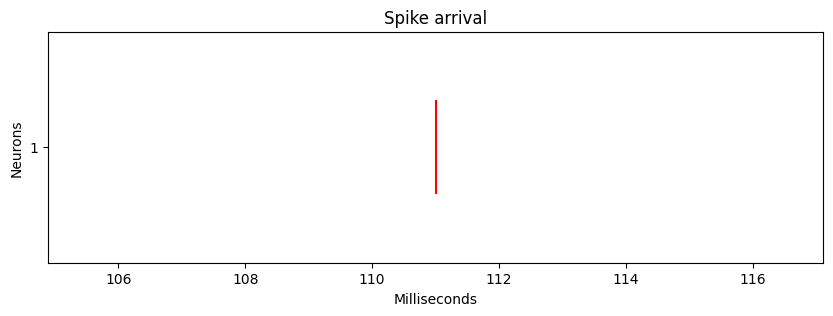

In [2]:
total_time = 0.3
dt = 0.001
num_neurons = 1
shape = (num_neurons,)
model_tag = None

num_steps = (int)(total_time // dt)

passive_layer = BSSNeuronProcessManualInput(name='PassiveNeuron', dt=dt, shape=shape,
                            physical_properties=Passive,
                            heights = (
                                3e-9, 0
                            ), times = (
                                0.1, 0.12
                            ))
neuron = TwoCompartmentNeuron(dt=dt, num_neurons=num_neurons, passive_layer=passive_layer)

passive_monitors = StandardNeuronMonitors(neuron.passive_layer, num_steps) # we'll monitor both types of neurons
sodium_monitors = StandardNeuronMonitors(neuron.sodium_layer, num_steps)

run_cfg = Loihi1SimCfg(select_tag=model_tag)
neuron.sodium_layer.run(condition=RunSteps(num_steps=num_steps), run_cfg=run_cfg)

plot_voltage_and_current('passive', [i * dt for i in range(num_steps)], 
                         passive_monitors.V_m_monitor.get_neuron_data(), 
                         passive_monitors.I_monitor.get_neuron_data())
plot_voltage_and_current('sodium', [i * dt for i in range(num_steps)], 
                         sodium_monitors.V_m_monitor.get_neuron_data(), 
                         sodium_monitors.I_monitor.get_neuron_data(), min_voltage_axis = -100e-3, max_voltage_axis=25e-3)

plot_spikes(spikes=[np.where(sodium_monitors.spike_monitor.get_neuron_data()[:, i])[0] for i in range(num_neurons)], 
            legend=[f'{i + 1}' for i in range(num_neurons)], 
            colors=['#ff0000' for _ in range(num_neurons)])

neuron.sodium_layer.stop()

## Three-Compartment Model

This is designed to imitate the system in figure 3B of the BSS-2 paper, which describes a three-compartment model of a passive compartment bridging a calcium dendrite to a sodium soma (calcium = plateau potential, sodium = AdEx). I'm feeding a short spike into the dendrite, and the sodium compartment spikes accordingly. It spikes multiple times since the dendrite is held at high voltage for a relatively long time.

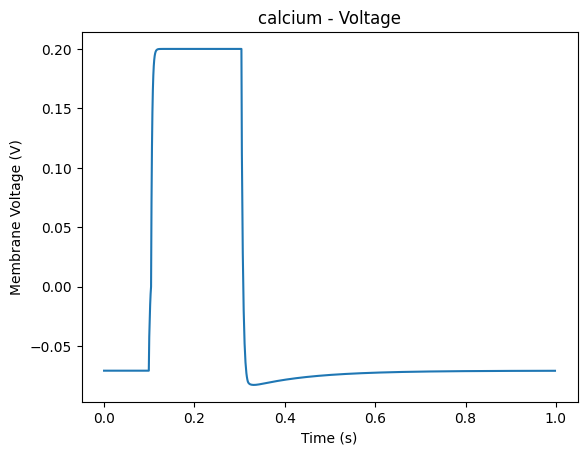

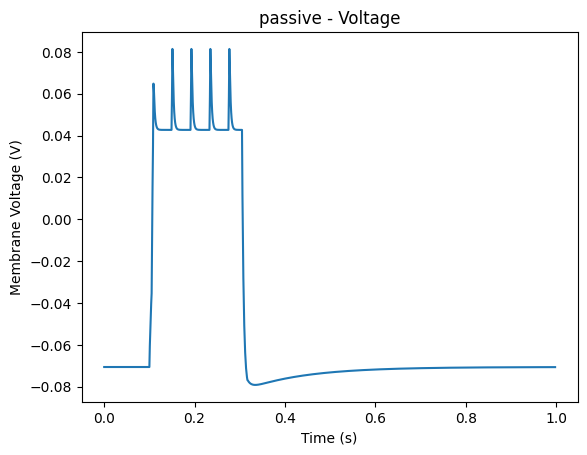

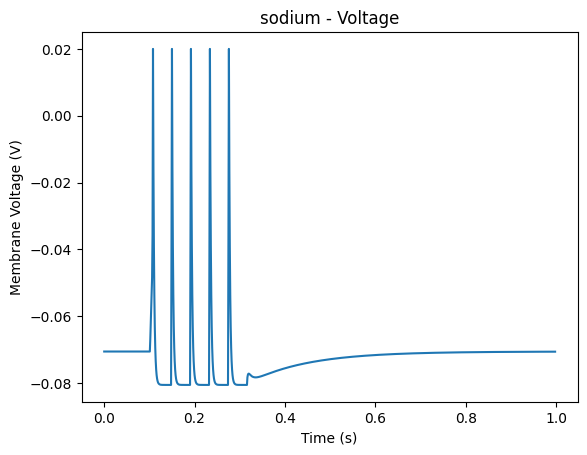

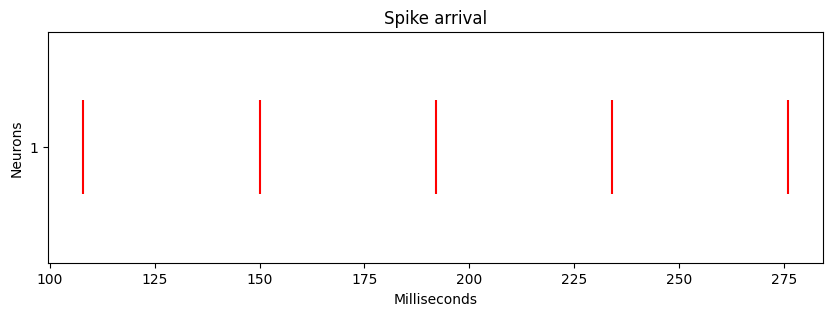

In [3]:
total_time = 1
dt = 0.001
dendrites_name = 'CalciumProcess'
passives_name = 'PassiveProcess'
somas_name = 'SodiumProcess'
num_neurons = 1
shape = (num_neurons,)
model_tag = None

num_steps = (int)(total_time // dt)

calcium_layer = BSSNeuronProcessManualInput(name=dendrites_name, dt=dt, shape=shape,
                            physical_properties=Plateau_Potential,
                            heights = (
                                8e-9, 0
                            ), times = (
                                0.1, 0.12
                            ))
neuron = ThreeCompartmentNeuron(dt=dt, num_neurons=num_neurons, calcium_layer=calcium_layer)

calcium_monitors = StandardNeuronMonitors(neuron.calcium_layer, num_steps)
passive_monitors = StandardNeuronMonitors(neuron.passive_layer, num_steps)
sodium_monitors = StandardNeuronMonitors(neuron.sodium_layer, num_steps)

run_cfg = Loihi1SimCfg(select_tag=model_tag)
neuron.sodium_layer.run(condition=RunSteps(num_steps=num_steps), run_cfg=run_cfg)

plot_voltage('calcium', [i * dt for i in range(num_steps)], 
                         calcium_monitors.V_m_monitor.get_neuron_data())
plot_voltage('passive', [i * dt for i in range(num_steps)], 
                         passive_monitors.V_m_monitor.get_neuron_data())
plot_voltage('sodium', [i * dt for i in range(num_steps)], 
                         sodium_monitors.V_m_monitor.get_neuron_data())

plot_spikes(spikes=[np.where(sodium_monitors.spike_monitor.get_neuron_data()[:, i])[0] for i in range(num_neurons)], 
            legend=[f'{i + 1}' for i in range(num_neurons)], 
            colors=['#ff0000' for _ in range(num_neurons)])

neuron.sodium_layer.stop()

## Double-Compartment Passive Chain

This is designed to imitate the system in figure 3C of the BSS-2 paper, which describes a chain of three passive neurons, each consisting of two passive compartments. I'm feeding a short triangle spike into the first compartment, and it propagates towards the other neurons. Since this system is totally homogenous, I'm putting all of the voltages on one graph. Notice how the curves come in pairs - this is because the compartments within each neuron are connected at high conductance, while neurons are connected to each other at a lower conductance.

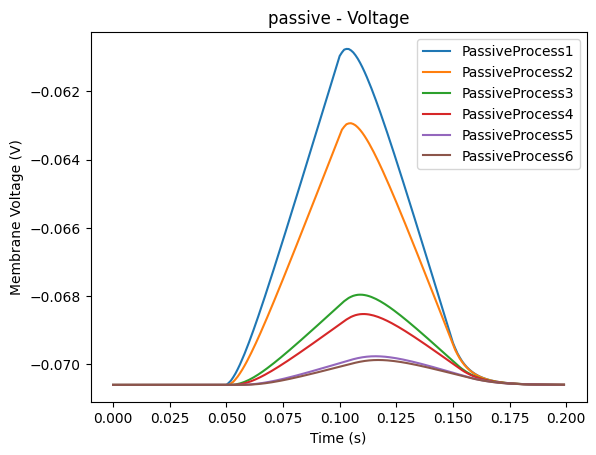

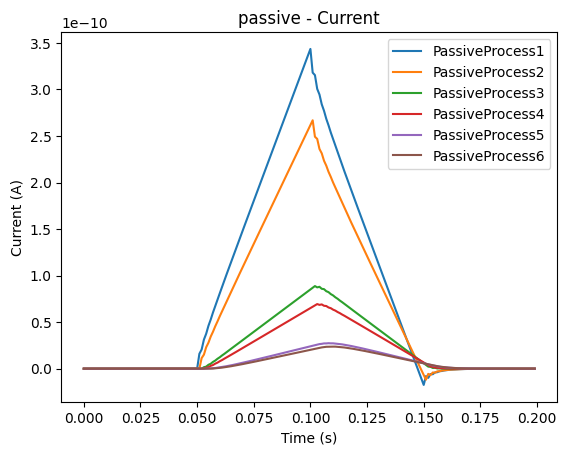

In [5]:
total_time = 0.2
dt = 0.001
model_tag = None

num_steps = (int)(total_time // dt)

layers = [
    BSSNeuronProcessTriangleSpike(name=f'Passive{i+1}', dt=dt, shape=(1,),
            physical_properties=Passive,
            heights=0.8e-9,
            starts=0.05,
            uptimes=0.05,
            downtimes=0.05)
    if i == 0 else BSSNeuronProcess(name=f'Passive{i + 1}', dt=dt, shape=shape, physical_properties=Passive)
    for i in range(6)]

neuron = DoubleCompartmentPassiveChain(dt=dt, num_neurons=1, layers=layers)

process_monitors = [StandardNeuronMonitors(process, num_steps) for process in neuron.layers]

run_cfg = Loihi1SimCfg(select_tag=model_tag)
neuron.layers[0].run(condition=RunSteps(num_steps=num_steps), run_cfg=run_cfg)

def reshape_data(data):
    return data.reshape((len(data),))

voltage_data = np.stack([reshape_data(monitor.V_m_monitor.get_neuron_data()) for monitor in process_monitors], axis=1)
current_data = np.stack([reshape_data(monitor.I_monitor.get_neuron_data()) for monitor in process_monitors], axis=1)

plot_voltage_and_current('passive', [i * dt for i in range(num_steps)], 
                         voltage_data, current_data, legend=process_names)

neuron.layers[0].stop()

## Branching Passive Chain

This is designed to imitate the system in figure 3D of the BSS-2 paper, which describes a tree of six passive neurons, where one branch of two neurons splits into two branches with two neurons each. Each neuron has two components, except for the branching neuron, which has three. I'm feeding a short triangle spike into the first compartment, and it propagates towards the other neurons.

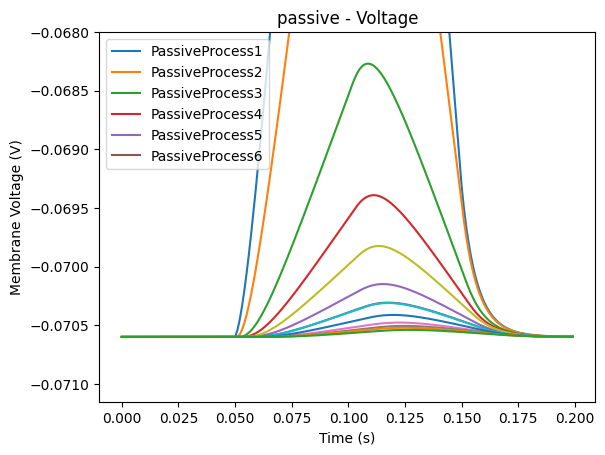

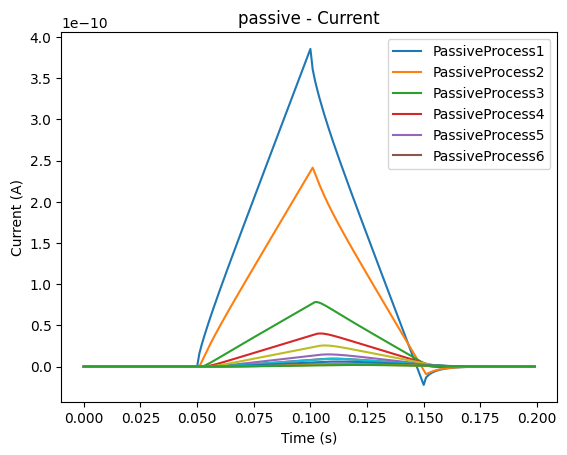

In [6]:
total_time = 0.2
dt = 0.001
model_tag = None

num_steps = (int)(total_time // dt)

layers = [
    BSSNeuronProcessTriangleSpike(name=f'Passive{i+1}', dt=dt, shape=(1,),
            physical_properties=Passive,
            heights=0.8e-9,
            starts=0.05,
            uptimes=0.05,
            downtimes=0.05)
    if i == 0 else BSSNeuronProcess(name=f'Passive{i + 1}', dt=dt, shape=shape, physical_properties=Passive)
    for i in range(13)]

neuron = BranchingPassiveChain(dt=dt, num_neurons=1, layers=layers)

process_monitors = [StandardNeuronMonitors(process, num_steps) for process in neuron.layers]

run_cfg = Loihi1SimCfg(select_tag=model_tag)
neuron.layers[0].run(condition=RunSteps(num_steps=num_steps), run_cfg=run_cfg)

def reshape_data(data):
    return data.reshape((len(data),))

voltage_data = np.stack([reshape_data(monitor.V_m_monitor.get_neuron_data()) for monitor in process_monitors], axis=1)
current_data = np.stack([reshape_data(monitor.I_monitor.get_neuron_data()) for monitor in process_monitors], axis=1)

plot_voltage_and_current('passive', [i * dt for i in range(num_steps)], 
                         voltage_data, current_data, legend=process_names, max_voltage_axis=-68e-3)

neuron.layers[0].stop()

## Four Branch Model

This is designed to imitate the system in figure 3E of the BSS-2 paper, which contains a central sodium neuron connected to four length-two passive branches. The sodium neuron has four compartments, and the passive neurons have one or two. I'm injecting currents into two of the far passive neurons, and if their start times are far apart (i.e. 0.05 and 0.15) the sodium neuron doesn't spike, whereas if they are close (i.e. 0.05 and 0.05) it will spike. 

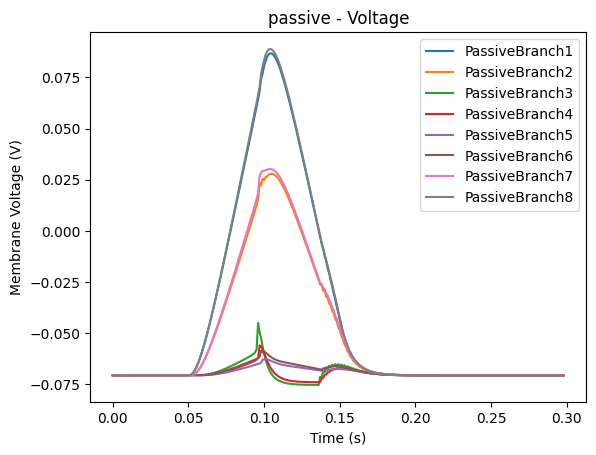

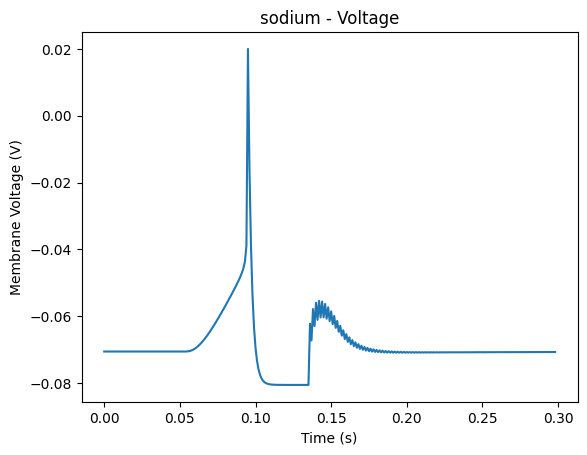

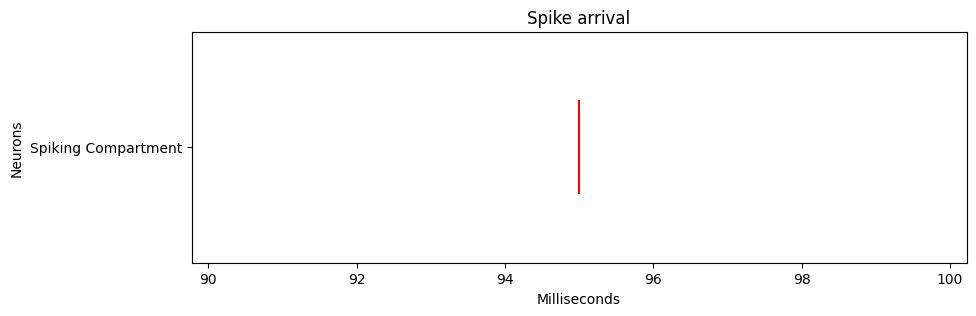

In [11]:
total_time = 0.3
dt = 0.001
model_tag = None

num_steps = (int)(total_time // dt)

start_times = [0.05, 0.05] # corresponds to each injection site
# ^ set to [0.05, 0.15] and [0.05, 0.05] and observe the difference

neuron = FourBranchNeuron(dt=dt, num_neurons=1, 
                          top_left_layer = BSSNeuronProcessTriangleSpike(
                            name='TopLeftNeuron', dt=dt, shape=shape,
                            physical_properties=Passive,
                            heights=2.5e-8,
                            starts=start_times[0],
                            uptimes=0.05,
                            downtimes=0.05),
                          bottom_right_layer = BSSNeuronProcessTriangleSpike(
                            name='BottomRightNeuron', dt=dt, shape=shape,
                            physical_properties=Passive,
                            heights=2.5e-8,
                            starts=start_times[1],
                            uptimes=0.05,
                            downtimes=0.05))

sodium_process_monitor = StandardNeuronMonitors(neuron.sodium_layer, num_steps)
passive_branch_monitors = [StandardNeuronMonitors(process, num_steps) for process in neuron.passive_branches]

run_cfg = Loihi1SimCfg(select_tag=model_tag)
neuron.sodium_layer.run(condition=RunSteps(num_steps=num_steps), run_cfg=run_cfg)

def reshape_data(data):
    return data.reshape((len(data),))

passive_voltage_data = np.stack([reshape_data(monitor.V_m_monitor.get_neuron_data()) for monitor in passive_branch_monitors], axis=1)
plot_voltage('passive', [i * dt for i in range(num_steps)], 
                         passive_voltage_data, legend=[process.name for process in neuron.passive_branches])
plot_voltage('sodium', [i * dt for i in range(num_steps)], 
                         sodium_process_monitor.V_m_monitor.get_neuron_data())
plot_spikes(spikes=[np.where(sodium_process_monitor.spike_monitor.get_neuron_data()[:, 0])[0]], 
            legend=['Spiking Compartment'], 
            colors=['#ff0000'])

neuron.sodium_layer.stop()

## Full Pyramidal Neuron Model

This is designed to imitate the system in figure 3F of the BSS-2 paper, which is a full model of a pyramidal neuron. It contains a sodium soma in the center connected to four two-neuron NMDA branches and one calcium neuron (bridged by a passive compartment) which itself is connected to three more NMDA branches. Neurons have varying numbers of compartments, and NMDA dynamics are represented using plateau potential. I'm injecting currents into all of the farthest NMDA components - when they are injecting at the same time, it causes a series of spikes from the sodium neuron, and when they are injected at different times, no spike is triggered.

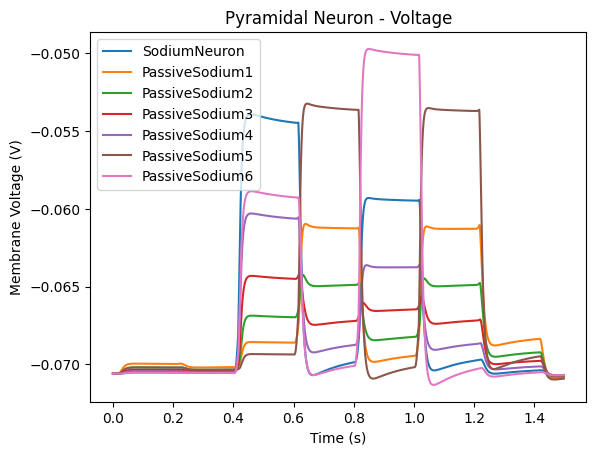

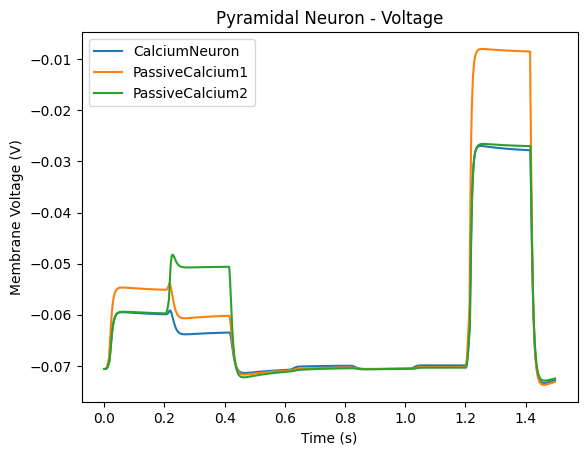

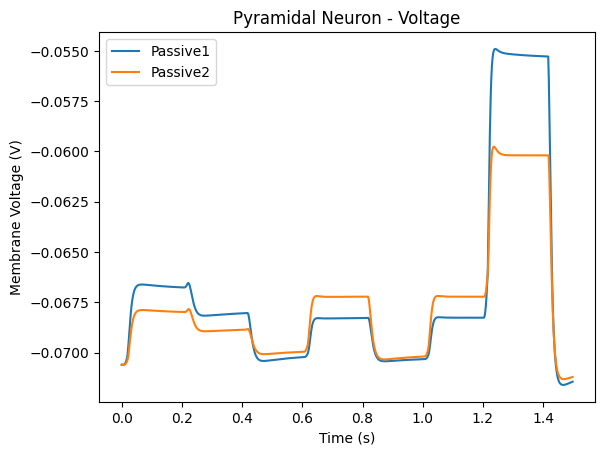

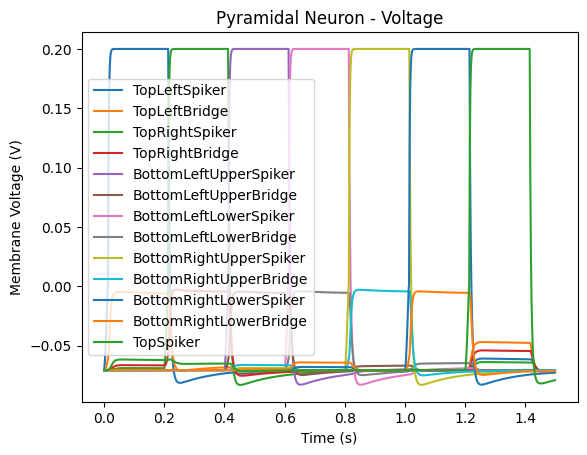

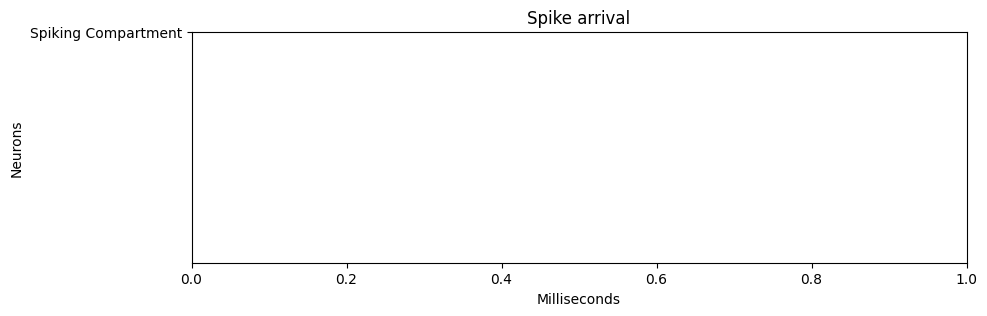

In [18]:
total_time = 1.5
dt = 0.001

model_tag = None

num_steps = (int)(total_time // dt)

def get_spike_time(i):
    return 0.2 * i

def make_spiking_nmda(name, i):
    return BSSNeuronProcessTriangleSpike(name=name, dt=dt, shape=(1,),
            heights=2.5e-8,
            starts=get_spike_time(i),
            uptimes=0.05,
            downtimes=0.05)

def make_nmda(name):
    return BSSNeuronProcess(name=name, dt=dt, shape=(1,))

neuron = PyramidalNeuron(dt=dt, num_neurons=1,
                         top_left_nmdas = [make_spiking_nmda('TopLeftSpiker', 0), make_nmda('TopLeftBridge')],
                         top_right_nmdas = [make_spiking_nmda('TopRightSpiker', 1), make_nmda('TopRightBridge')],
                         bottom_left_upper_nmdas = [make_spiking_nmda('BottomLeftUpperSpiker', 2), make_nmda('BottomLeftUpperBridge')],
                         bottom_left_lower_nmdas = [make_spiking_nmda('BottomLeftLowerSpiker', 3), make_nmda('BottomLeftLowerBridge')],
                         bottom_right_upper_nmdas = [make_spiking_nmda('BottomRightUpperSpiker', 4), make_nmda('BottomRightUpperBridge')],
                         bottom_right_lower_nmdas = [make_spiking_nmda('BottomRightLowerSpiker', 5), make_nmda('BottomRightLowerBridge')],
                         top_nmda = make_spiking_nmda('TopSpiker', 6))

process_groups = [
    [[neuron.sodium_layer], neuron.sodium_passive_layers],
    [[neuron.calcium_layer], neuron.calcium_passive_layers],
    [neuron.passive_layers],
    [neuron.top_left_nmdas, neuron.top_right_nmdas, neuron.bottom_left_upper_nmdas, neuron.bottom_left_lower_nmdas,
     neuron.bottom_right_upper_nmdas, neuron.bottom_right_lower_nmdas, [neuron.top_nmda]]
]
    

all_monitors = [
    [StandardNeuronMonitors(process, num_steps) for processes in process_group for process in processes]
    for process_group in process_groups
]

run_cfg = Loihi1SimCfg(select_tag=model_tag)
neuron.sodium_layer.run(condition=RunSteps(num_steps=num_steps), run_cfg=run_cfg)

def reshape_data(data):
    return data.reshape((len(data),))

for monitors in all_monitors:
    voltage_data = np.stack([reshape_data(monitor.V_m_monitor.get_neuron_data()) for monitor in monitors], axis=1)
    plot_voltage('Pyramidal Neuron', [i * dt for i in range(num_steps)], 
                             voltage_data, legend=[monitor.V_m_monitor.neuron_name for monitor in monitors])
    
plot_spikes(spikes=[np.where(all_monitors[0][0].spike_monitor.get_neuron_data()[:, 0])[0]], 
            legend=['Spiking Compartment'], 
            colors=['#ff0000'])

neuron.sodium_layer.stop()

## Single-Compartment Passive Chain

This is a replication of the Double-Compartment Passive Chain experiment above, except that each passive component is represented by only one compartment instead of two. This allows current to travel more efficiently between passive components (no unnecessary loss due to internal connections).

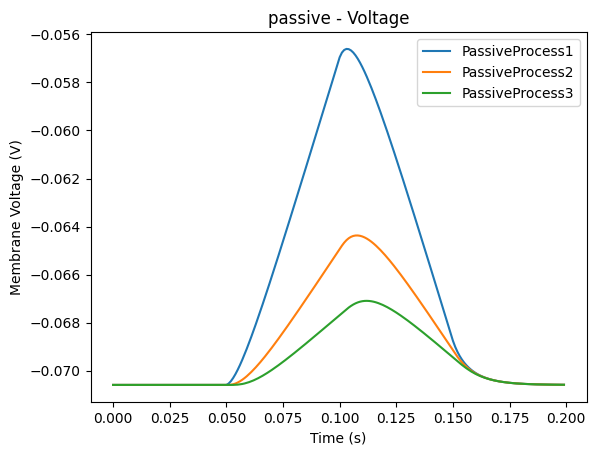

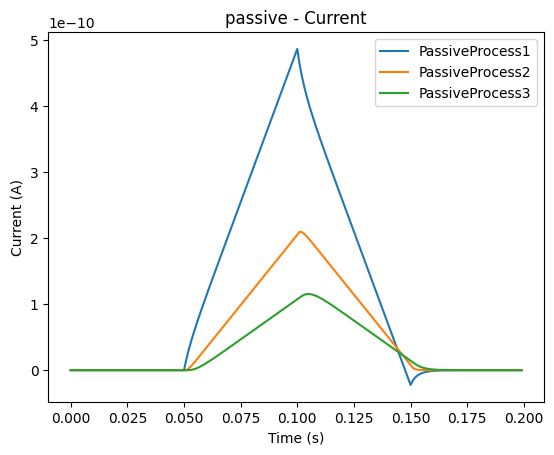

In [19]:
total_time = 0.2
dt = 0.001
model_tag = None

num_steps = (int)(total_time // dt)

layers = [
    BSSNeuronProcessTriangleSpike(name=f'Passive{i+1}', dt=dt, shape=(1,),
            physical_properties=Passive,
            heights=0.8e-9,
            starts=0.05,
            uptimes=0.05,
            downtimes=0.05)
    if i == 0 else BSSNeuronProcess(name=f'Passive{i + 1}', dt=dt, shape=shape, physical_properties=Passive)
    for i in range(3)]

neuron = SingleCompartmentPassiveChain(dt=dt, num_neurons=1, layers=layers)

process_monitors = [StandardNeuronMonitors(process, num_steps) for process in neuron.layers]

run_cfg = Loihi1SimCfg(select_tag=model_tag)
neuron.layers[0].run(condition=RunSteps(num_steps=num_steps), run_cfg=run_cfg)

def reshape_data(data):
    return data.reshape((len(data),))

voltage_data = np.stack([reshape_data(monitor.V_m_monitor.get_neuron_data()) for monitor in process_monitors], axis=1)
current_data = np.stack([reshape_data(monitor.I_monitor.get_neuron_data()) for monitor in process_monitors], axis=1)

plot_voltage_and_current('passive', [i * dt for i in range(num_steps)], 
                         voltage_data, current_data, legend=process_names)

neuron.layers[0].stop()

## Single-Compartment Branching Passive Chain

This is a replication of the Branching Passive Chain experiment above, except that each passive component is represented by one compartment instead of two, leading to more efficient current propagation.

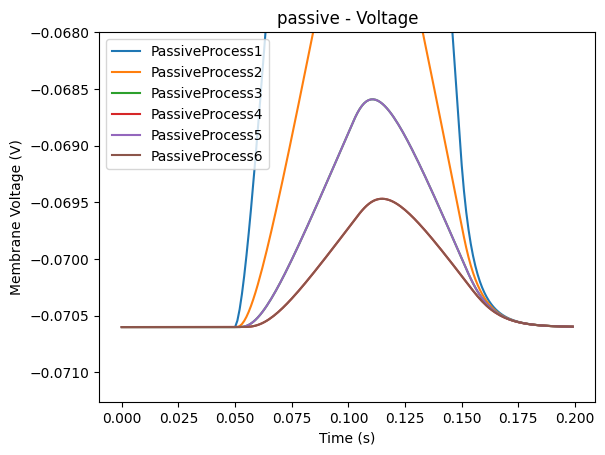

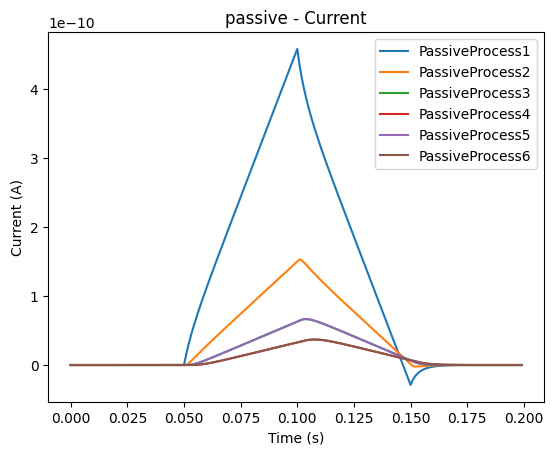

In [21]:
total_time = 0.2
dt = 0.001
model_tag = None

num_steps = (int)(total_time // dt)

layers = [
    BSSNeuronProcessTriangleSpike(name=f'Passive{i+1}', dt=dt, shape=(1,),
            physical_properties=Passive,
            heights=0.8e-9,
            starts=0.05,
            uptimes=0.05,
            downtimes=0.05)
    if i == 0 else BSSNeuronProcess(name=f'Passive{i + 1}', dt=dt, shape=shape, physical_properties=Passive)
    for i in range(6)]

neuron = SingleCompartmentBranchingPassiveChain(dt=dt, num_neurons=1, layers=layers)

process_monitors = [StandardNeuronMonitors(process, num_steps) for process in neuron.layers]

run_cfg = Loihi1SimCfg(select_tag=model_tag)
neuron.layers[0].run(condition=RunSteps(num_steps=num_steps), run_cfg=run_cfg)

def reshape_data(data):
    return data.reshape((len(data),))

voltage_data = np.stack([reshape_data(monitor.V_m_monitor.get_neuron_data()) for monitor in process_monitors], axis=1)
current_data = np.stack([reshape_data(monitor.I_monitor.get_neuron_data()) for monitor in process_monitors], axis=1)

plot_voltage_and_current('passive', [i * dt for i in range(num_steps)], 
                         voltage_data, current_data, legend=process_names, max_voltage_axis=-68e-3)

neuron.layers[0].stop()

## Single-Compartment Four Branch Model

This is a replication of the Four Branch Model experiment above, except that each passive/sodium component is represented by one compartment instead of two, leading to more efficient current propagation.

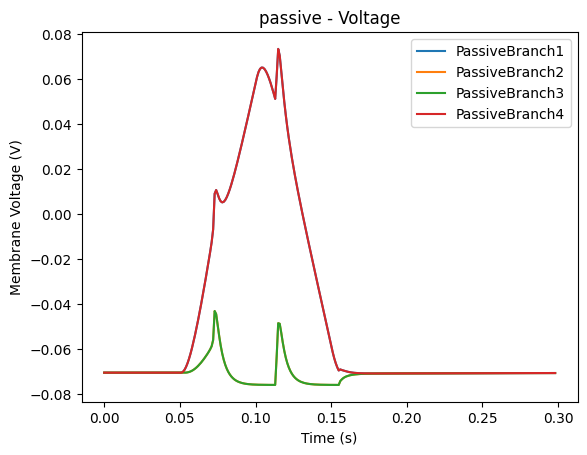

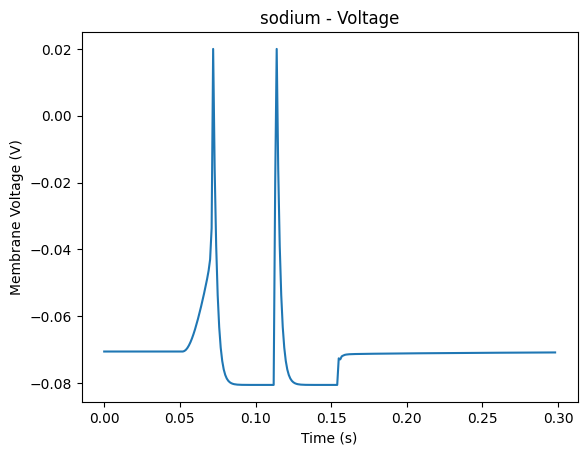

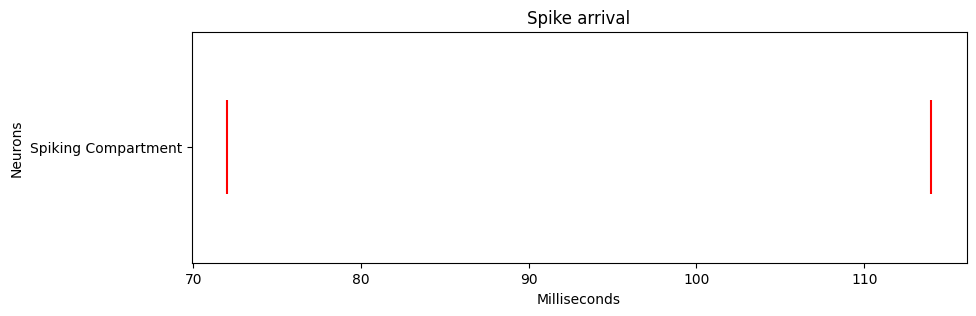

In [22]:
total_time = 0.3
dt = 0.001
model_tag = None

num_steps = (int)(total_time // dt)

start_times = [0.05, 0.05] # corresponds to each injection site
# ^ set to [0.05, 0.15] and [0.05, 0.05] and observe the difference

neuron = SingleCompartmentFourBranchNeuron(dt=dt, num_neurons=1, 
                          top_left_layer = BSSNeuronProcessTriangleSpike(
                            name='TopLeftNeuron', dt=dt, shape=shape,
                            physical_properties=Passive,
                            heights=2.5e-8,
                            starts=start_times[0],
                            uptimes=0.05,
                            downtimes=0.05),
                          bottom_right_layer = BSSNeuronProcessTriangleSpike(
                            name='BottomRightNeuron', dt=dt, shape=shape,
                            physical_properties=Passive,
                            heights=2.5e-8,
                            starts=start_times[1],
                            uptimes=0.05,
                            downtimes=0.05))

sodium_process_monitor = StandardNeuronMonitors(neuron.sodium_layer, num_steps)
passive_branch_monitors = [StandardNeuronMonitors(process, num_steps) for process in neuron.passive_branches]

run_cfg = Loihi1SimCfg(select_tag=model_tag)
neuron.sodium_layer.run(condition=RunSteps(num_steps=num_steps), run_cfg=run_cfg)

def reshape_data(data):
    return data.reshape((len(data),))

passive_voltage_data = np.stack([reshape_data(monitor.V_m_monitor.get_neuron_data()) for monitor in passive_branch_monitors], axis=1)
plot_voltage('passive', [i * dt for i in range(num_steps)], 
                         passive_voltage_data, legend=[process.name for process in neuron.passive_branches])
plot_voltage('sodium', [i * dt for i in range(num_steps)], 
                         sodium_process_monitor.V_m_monitor.get_neuron_data())
plot_spikes(spikes=[np.where(sodium_process_monitor.spike_monitor.get_neuron_data()[:, 0])[0]], 
            legend=['Spiking Compartment'], 
            colors=['#ff0000'])

neuron.sodium_layer.stop()

## Single-Compartment Pyramidal Neuron Model

This is a replication of the Pyramidal Neuron Model experiment above, except that each passive/sodium component is represented by one compartment instead of two, leading to more efficient current propagation. In this experiment, we stimulate the three NMDA branches connected to the Calcium. When they are stimulated at different times, the Calcium doesn't spike. When they are stimulated together, the Calcium spikes and plateaus, leading to spikes in the Sodium (firing) compartment.

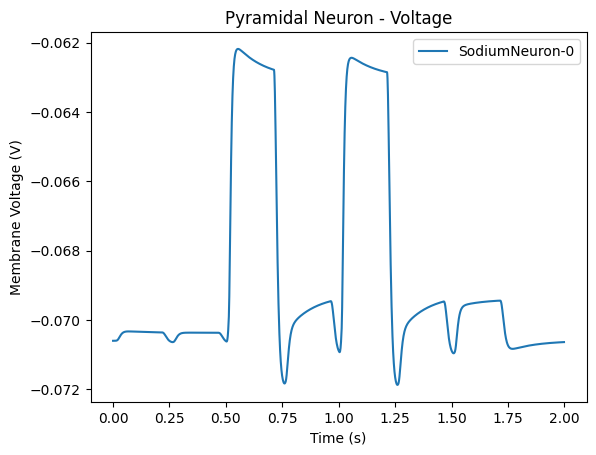

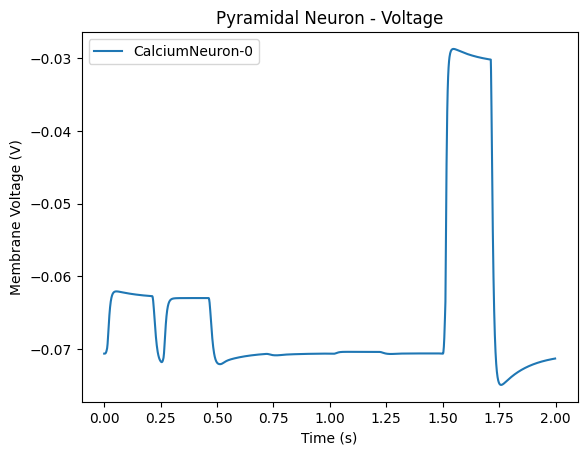

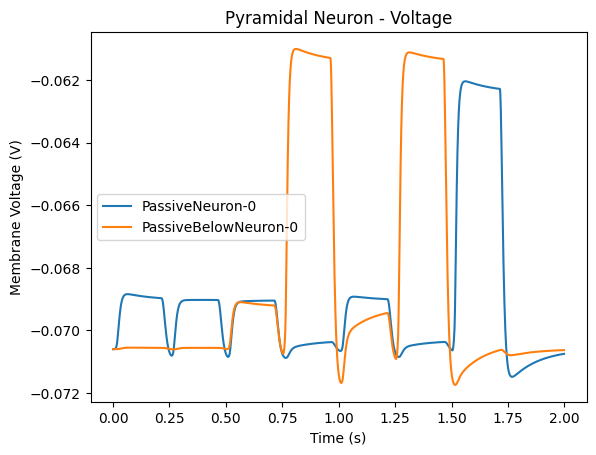

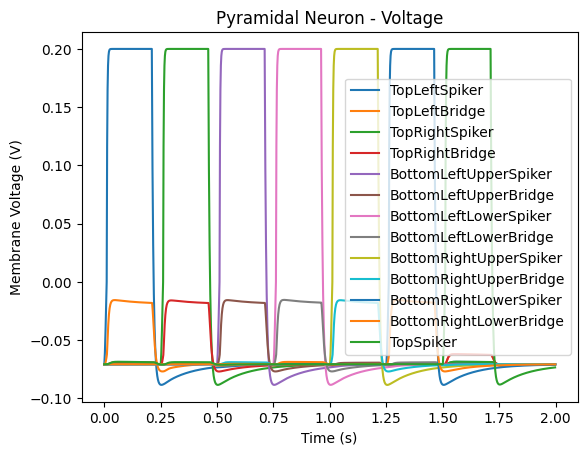

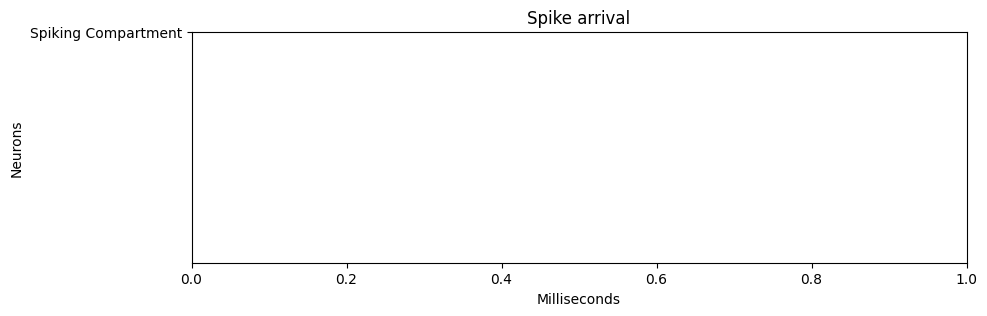

In [4]:
total_time = 2
dt = 0.001

model_tag = None

num_steps = (int)(total_time // dt)

def get_spike_time(i):
    return 0.25 * i

def make_spiking_nmda(name, i):
    return BSSNeuronProcessTriangleSpike(name=name, dt=dt, shape=(1,),
            heights=2.5e-8,
            starts=get_spike_time(i),
            uptimes=0.05,
            downtimes=0.05)

def make_nmda(name):
    return BSSNeuronProcess(name=name, dt=dt, shape=(1,))

neuron = SingleCompartmentPyramidalNeuron(dt=dt, num_neurons=1,
                         top_left_nmdas = [make_spiking_nmda('TopLeftSpiker', 0), make_nmda('TopLeftBridge')],
                         top_right_nmdas = [make_spiking_nmda('TopRightSpiker', 1), make_nmda('TopRightBridge')],
                         bottom_left_upper_nmdas = [make_spiking_nmda('BottomLeftUpperSpiker', 2), make_nmda('BottomLeftUpperBridge')],
                         bottom_left_lower_nmdas = [make_spiking_nmda('BottomLeftLowerSpiker', 3), make_nmda('BottomLeftLowerBridge')],
                         bottom_right_upper_nmdas = [make_spiking_nmda('BottomRightUpperSpiker', 4), make_nmda('BottomRightUpperBridge')],
                         bottom_right_lower_nmdas = [make_spiking_nmda('BottomRightLowerSpiker', 5), make_nmda('BottomRightLowerBridge')],
                         top_nmda = make_spiking_nmda('TopSpiker', 6), conductance=1e-8)

process_groups = [
    [[neuron.sodium_layer]],
    [[neuron.calcium_layer]],
    [[neuron.passive_layer], [neuron.passive_layer_below]],
    [neuron.top_left_nmdas, neuron.top_right_nmdas, neuron.bottom_left_upper_nmdas, neuron.bottom_left_lower_nmdas,
     neuron.bottom_right_upper_nmdas, neuron.bottom_right_lower_nmdas, [neuron.top_nmda]]
]
    

all_monitors = [
    [StandardNeuronMonitors(process, num_steps) for processes in process_group for process in processes]
    for process_group in process_groups
]

run_cfg = Loihi1SimCfg(select_tag=model_tag)
neuron.sodium_layer.run(condition=RunSteps(num_steps=num_steps), run_cfg=run_cfg)

def reshape_data(data):
    return data.reshape((len(data),))

for monitors in all_monitors:
    voltage_data = np.stack([reshape_data(monitor.V_m_monitor.get_neuron_data()) for monitor in monitors], axis=1)
    plot_voltage('Pyramidal Neuron', [i * dt for i in range(num_steps)], 
                             voltage_data, legend=[monitor.V_m_monitor.neuron_name for monitor in monitors])
    
plot_spikes(spikes=[np.where(all_monitors[0][0].spike_monitor.get_neuron_data()[:, 0])[0]], 
            legend=['Spiking Compartment'], 
            colors=['#ff0000'])

neuron.sodium_layer.stop()

## Scaling the Three-Compartment Model

This experiment sends a single triangle spike to the dendrite of the first neuron in an array of 171 three-compartment neurons. Each neuron is connected via synapse to the next, so the axon spike of the first sends current to the dendrite of the second, and so on. Eventually the signal reaches the last neuron! Note the exponential decay in calcium (dendrite) current, which is due to the decay of synapse strength over time.

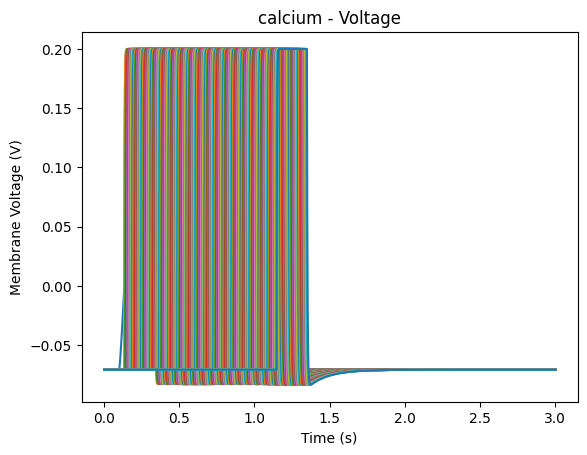

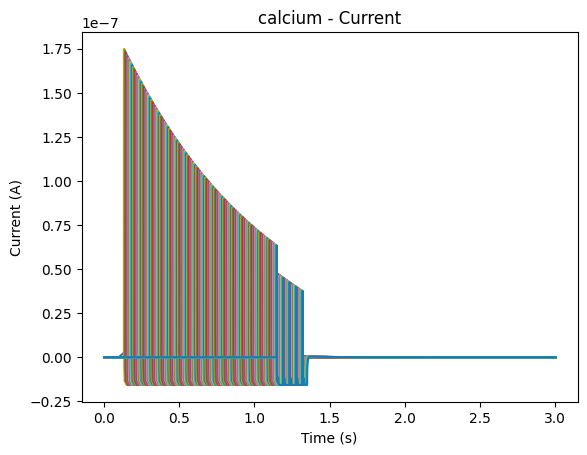

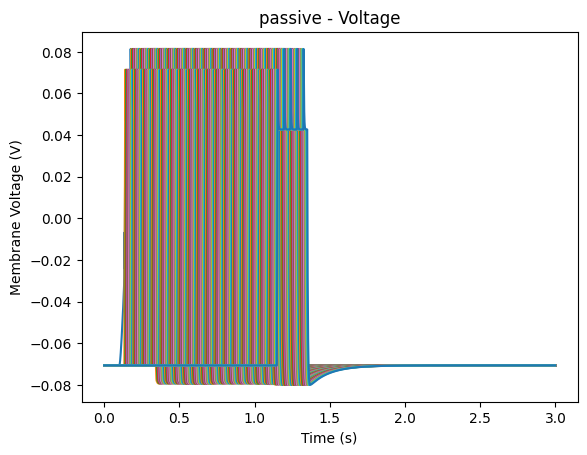

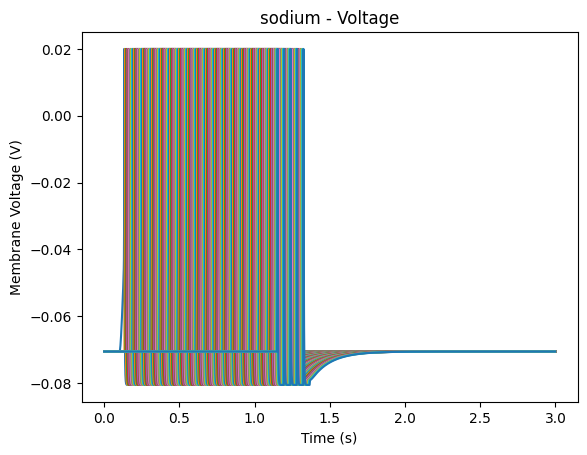

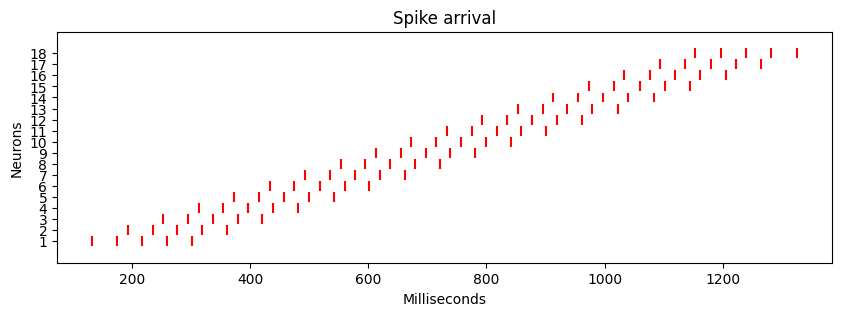

In [29]:
total_time = 3
dt = 0.001
num_neurons = 171 # * 3 ~= 512, so this would fill the entire BSS2 board
model_tag = None

num_steps = (int)(total_time // dt)

base_weight = 2e-7

calcium_layer = BSSNeuronProcessTriangleSpike(name=dendrites_name, dt=dt, shape=(num_neurons,),
                            physical_properties=Plateau_Potential,
                            synapse_weights = [
                                [base_weight if j == i - 1 else 0 for j in range(num_neurons)]
                                for i in range(num_neurons)
                            ], # this weight matrix shifts right, i.e. a spike from neuron 1 passes to neuron 2, etc
                            starts = 0.1,
                            heights = [8e-9 if i == 0 else 0 for i in range(num_neurons)], 
                            uptimes = 0.05,
                            downtimes = 0.05)
neuron = ThreeCompartmentNeuron(dt=dt, num_neurons=num_neurons, calcium_layer=calcium_layer)

neuron.sodium_layer.spike_out.connect(neuron.calcium_layer.synapse_in) # hook up the synapses

calcium_monitors = StandardNeuronMonitors(neuron.calcium_layer, num_steps)
passive_monitors = StandardNeuronMonitors(neuron.passive_layer, num_steps)
sodium_monitors = StandardNeuronMonitors(neuron.sodium_layer, num_steps)

run_cfg = Loihi1SimCfg(select_tag=model_tag)
neuron.sodium_layer.run(condition=RunSteps(num_steps=num_steps), run_cfg=run_cfg)

plot_voltage_and_current('calcium', [i * dt for i in range(num_steps)], 
                         calcium_monitors.V_m_monitor.get_neuron_data(),
                        calcium_monitors.I_monitor.get_neuron_data())
plot_voltage('passive', [i * dt for i in range(num_steps)], 
                         passive_monitors.V_m_monitor.get_neuron_data())
plot_voltage('sodium', [i * dt for i in range(num_steps)], 
                         sodium_monitors.V_m_monitor.get_neuron_data())

spike_data = sodium_monitors.spike_monitor.get_neuron_data()
chosen_neurons = [np.where(spike_data[:, i])[0] for i in range(num_neurons) if i % 10 == 0]
plot_spikes(spikes=chosen_neurons, 
            legend=[f'{i + 1}' for i in range(len(chosen_neurons))], 
            colors=['#ff0000' for _ in range(len(chosen_neurons))])

neuron.sodium_layer.stop()

## Scaling the Four Branch Model

This experiment sends a single triangle spike to dendrite 5 on the middle neuron in an array of 57 four-branch neurons. Each neuron is connected via synapse to dendrites 1 and 4 on the other neurons - dendrite 1 shifts right, and dendrite 4 shifts left. That is, when the middle neuron fires, it will induce a current on dendrite 1 of the next neuron on the right, and a current on dendrite 4 of the next neuron on the left. The signals continue to spread through these neurons in both directions to produce a V pattern in terms of spiking (see last graph).

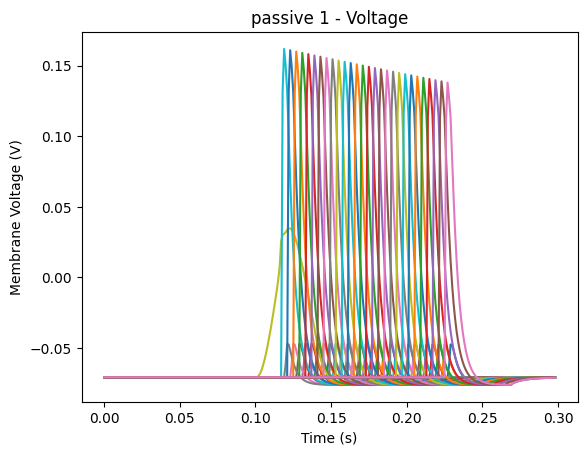

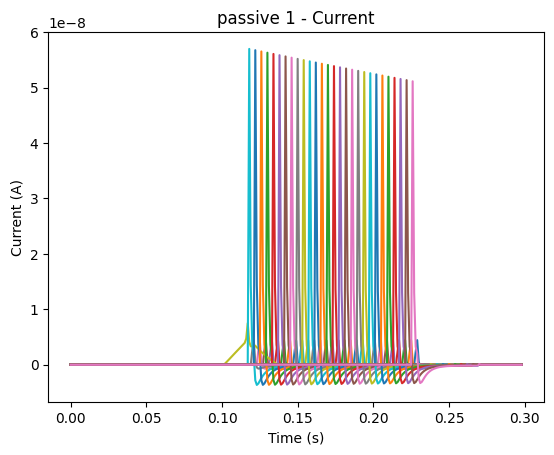

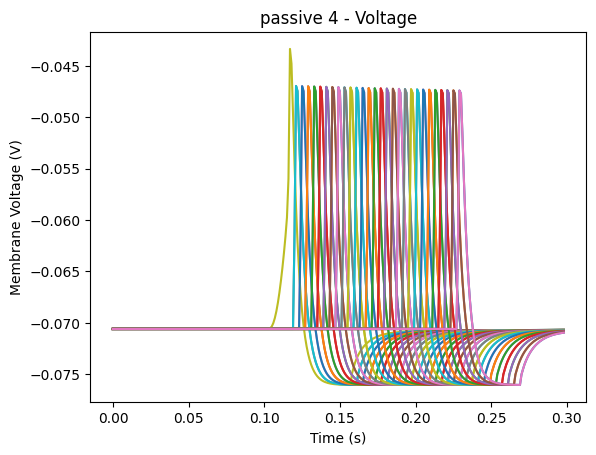

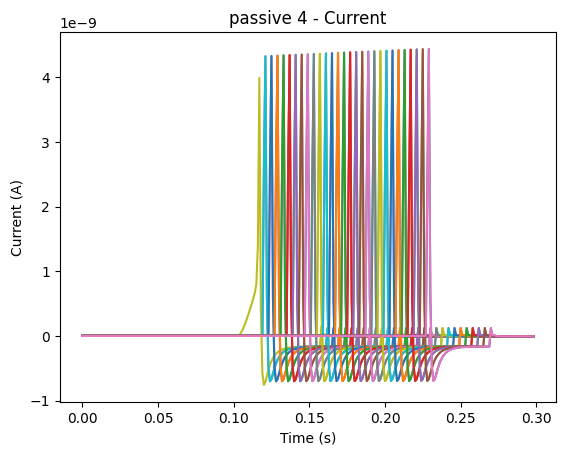

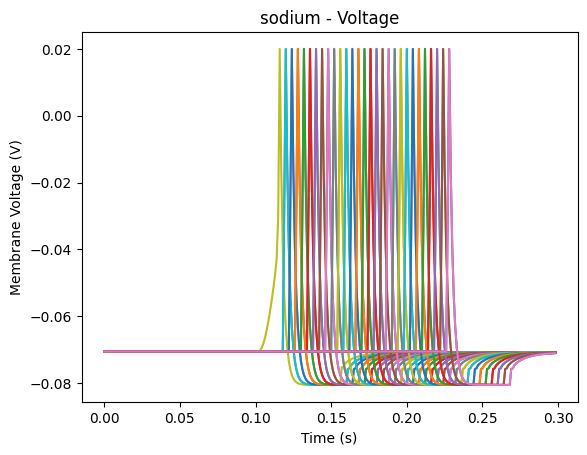

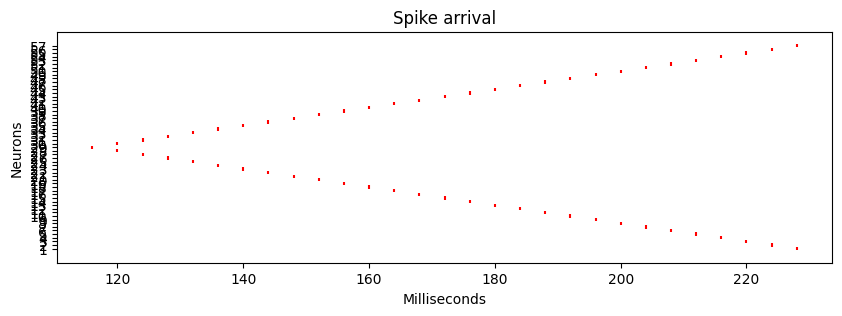

In [33]:
total_time = 0.3
dt = 0.001
num_neurons = 57 # * 9 ~= 512, so this would fill the BSS-2 board
shape=(num_neurons,)
stimulated_index = 28

model_tag = None

num_steps = (int)(total_time // dt)

base_weight = 3e-7


passive_processes = []

left_weights = [ # shifts right
    [base_weight if (j == i - 1 and i > stimulated_index) else 0 for j in range(num_neurons)]
    for i in range(num_neurons)
]

right_weights = [ # shifts left
    [base_weight if (j == i + 1 and i < stimulated_index) else 0for j in range(num_neurons)]
    for i in range(num_neurons)
]

top_left_layer = BSSNeuronProcessTriangleSpike(name='TopLeftNeuron', dt=dt, shape=shape,
            synapse_weights = left_weights,
            heights=[2e-8 if i == stimulated_index else 0 for i in range(num_neurons)],
            starts=0.1,
            uptimes=0.02,
            downtimes=0.02)
top_right_layer = BSSNeuronProcessTriangleSpike(name='TopRightNeuron', dt=dt, shape=shape,
            synapse_weights = right_weights,
            heights=[2e-8 if i == stimulated_index else 0 for i in range(num_neurons)],
            starts=0.1,
            uptimes=0.02,
            downtimes=0.02)

neuron = SingleCompartmentFourBranchNeuron(dt=dt, num_neurons=num_neurons, top_left_layer=top_left_layer, top_right_layer=top_right_layer)

neuron.sodium_layer.spike_out.connect(neuron.top_left_layer.synapse_in)
neuron.sodium_layer.spike_out.connect(neuron.top_right_layer.synapse_in)

sodium_process_monitor = StandardNeuronMonitors(neuron.sodium_layer, num_steps)
passive_process_monitors = [StandardNeuronMonitors(process, num_steps) for process in neuron.passive_branches]

run_cfg = Loihi1SimCfg(select_tag=model_tag)
neuron.sodium_layer.run(condition=RunSteps(num_steps=num_steps), run_cfg=run_cfg)

for n in (0, 3):
    plot_voltage_and_current(f'passive {n + 1}', [i * dt for i in range(num_steps)], 
                             passive_process_monitors[n].V_m_monitor.get_neuron_data(), 
                             passive_process_monitors[n].I_monitor.get_neuron_data())

sodium_voltage_data = sodium_process_monitor.V_m_monitor.get_neuron_data()
plot_voltage('sodium', [i * dt for i in range(num_steps)], 
                         sodium_voltage_data)
plot_spikes(spikes=[np.where(sodium_process_monitor.spike_monitor.get_neuron_data()[:, i])[0] for i in range(num_neurons)], 
            legend=[f'{i + 1}' for i in range(num_neurons)], 
            colors=['#ff0000' for i in range(num_neurons)])

neuron.sodium_layer.stop()

## Scaling the Pyramidal Neuron Model

This experiment performs the following with 30 pyramidal neurons:
* Neurons 0 and 20 receive triangle spikes at t = 0.1s (these can be toggled with send_left_signal and send_right_signal)
* N0 passes to N1 via synapse, N1 passes to N2, and so on until N9
* Likewise, N20 passes to N19, N19 to N18, and so on until N11
* All of these synapses above occur at dendrite 5, which is directly connected to the Sodium soma/axon
* N11 and N9 fire at the same time. They are both connected to N10, through dendrites 0 and 4, respectively
* These dendrites are connected to the Calcium component, which will only fire if it receives two inputs at the same time
* Since N10 receives these signals at the same time, the Calcium fires (plateau) and triggers the Sodium to fire as well
* N10 passes to N21
* N21 passes to N22, N22 passes to N23, and so on until the pulse finally reaches N29
  
Also, I've modified the Sodium (AdEx) firing components to only fire once instead of the usual five times, so the graphs are easier to read.

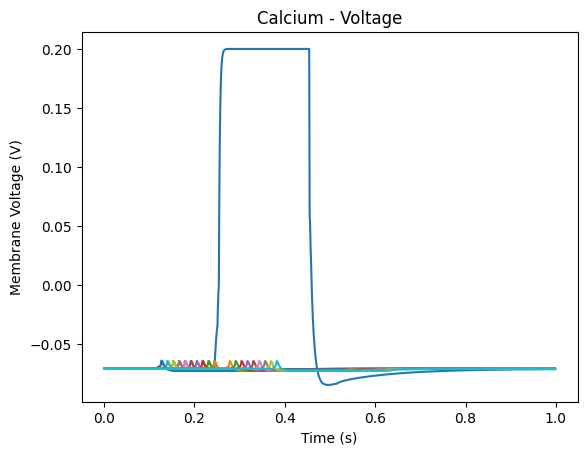

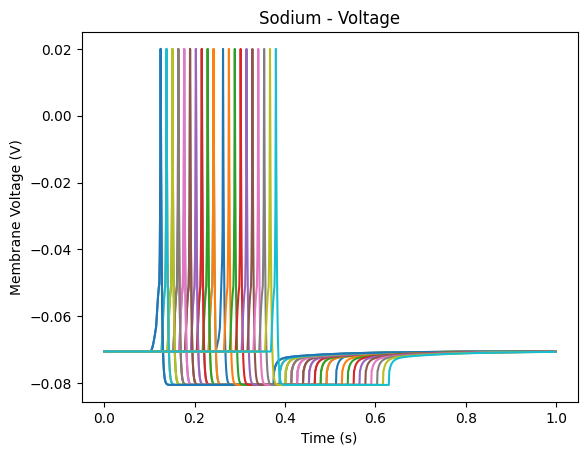

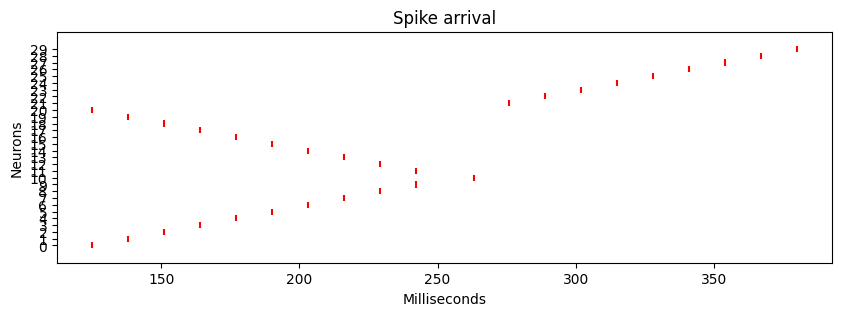

In [36]:
send_left_signal = True
send_right_signal = True

total_time = 1.0
dt = 0.001

num_neurons = 30 # * 17 ~= 512, so this would fill a BSS-2 board
shape = (num_neurons,)
model_tag = None

num_steps = (int)(total_time // dt)

base_weight = 1e-7

first_phase_weights = [ # 0-9 shift right, 11-20 shift left
    [base_weight if ((j == i - 1 and i > 0 and i < 10) or (j == i + 1 and i > 10 and i < 20)) else 0 for j in range(num_neurons)]
    for i in range(num_neurons)
]

second_phase_weights = [ # 21 gets triggered by 10, 22-29 shift right
    [base_weight if ((j == i - 1 and i > 21) or (j == 10 and i == 21)) else 0 for j in range(num_neurons)]
    for i in range(num_neurons)
]

branch_point_weights_1 = [ # transfers 9 to 10
    [base_weight if (i == 10 and j == 9) else 0 for j in range(num_neurons)]
    for i in range(num_neurons)
]

branch_point_weights_2 = [ # transfers 11 to 10
    [base_weight if (i == 10 and j == 11) else 0 for j in range(num_neurons)]
    for i in range(num_neurons)
]

modified_AdEx = copy(AdEx)
modified_AdEx.t_r = 0.25
nmda_properties = copy(Plateau_Potential)
nmda_properties.V_r = 100e-3

first_phase_dendrite = BSSNeuronProcessTriangleSpike(name='FirstPhaseDendrite', dt=dt, shape=shape,
            synapse_weights=first_phase_weights,
            heights=[2.5e-8 if ((i == 0 and send_left_signal) or (i == 20 and send_right_signal)) else 0 for i in range(num_neurons)],
            starts=0.1,
            uptimes=0.05,
            downtimes=0.05)
second_phase_dendrite = BSSNeuronProcess(name='SecondPhaseDendrite', dt=dt, shape=shape, synapse_weights=second_phase_weights)
branch_point_dendrite_1 = BSSNeuronProcess(name='BranchDendrite1', dt=dt, shape=shape, synapse_weights=branch_point_weights_1)
branch_point_dendrite_2 = BSSNeuronProcess(name='BranchDendrite2', dt=dt, shape=shape, synapse_weights=branch_point_weights_2)

neuron = SingleCompartmentPyramidalNeuron(dt=dt, num_neurons=num_neurons,
                                          top_left_nmdas = [branch_point_dendrite_1, BSSNeuronProcess(name='BranchDendrite1Bridge', dt=dt, shape=shape)],
                                          top_right_nmdas = [branch_point_dendrite_2, BSSNeuronProcess(name='BranchDendrite2Bridge', dt=dt, shape=shape)],
                                          bottom_left_upper_nmdas = [first_phase_dendrite, BSSNeuronProcess(name='FirstPhaseBridge', dt=dt, shape=shape)],
                                          bottom_right_upper_nmdas = [second_phase_dendrite, BSSNeuronProcess(name='SecondPhaseBridge', dt=dt, shape=shape)],
                                          nmda_pp = nmda_properties, sodium_pp = modified_AdEx)

neuron.sodium_layer.spike_out.connect(neuron.top_left_nmdas[0].synapse_in)
neuron.sodium_layer.spike_out.connect(neuron.top_right_nmdas[0].synapse_in)
neuron.sodium_layer.spike_out.connect(neuron.bottom_left_upper_nmdas[0].synapse_in)
neuron.sodium_layer.spike_out.connect(neuron.bottom_right_upper_nmdas[0].synapse_in)

sodium_monitors = StandardNeuronMonitors(neuron.sodium_layer, num_steps)
calcium_monitors = StandardNeuronMonitors(neuron.calcium_layer, num_steps)

run_cfg = Loihi1SimCfg(select_tag=model_tag)
neuron.sodium_layer.run(condition=RunSteps(num_steps=num_steps), run_cfg=run_cfg)

plot_voltage('Calcium', [i * dt for i in range(num_steps)], calcium_monitors.V_m_monitor.get_neuron_data())
plot_voltage('Sodium', [i * dt for i in range(num_steps)], sodium_monitors.V_m_monitor.get_neuron_data())

spike_data = sodium_monitors.spike_monitor.get_neuron_data()
plot_spikes(spikes=[np.where(spike_data[:, i])[0] for i in range(num_neurons)], 
            legend=[f'{i}' for i in range(num_neurons)], 
            colors=['#ff0000' for i in range(num_neurons)])

neuron.sodium_layer.stop()

## Larger Scaling

Here, I'm checking the speed of running large numbers of different types of neurons, where each neuron has one synapse. As you can see, the time begins to get unreasonable with a large number of neurons and a synapse, because the synapse matrix is so massive.

Beginning tests with 1 neurons.

Now running Three Compartment Neuron with 1 neurons and without synapse...
Took 0:00:00.319316
Now running Four Branch Neuron with 1 neurons and without synapse...
Took 0:00:00.930827
Now running Pyramidal Neuron with 1 neurons and without synapse...
Took 0:00:01.786583

Now running Three Compartment Neuron with 1 neurons and with synapse...
Took 0:00:00.346456
Now running Four Branch Neuron with 1 neurons and with synapse...
Took 0:00:00.872309
Now running Pyramidal Neuron with 1 neurons and with synapse...
Took 0:00:01.503506

Beginning tests with 10 neurons.

Now running Three Compartment Neuron with 10 neurons and without synapse...
Took 0:00:00.362248
Now running Four Branch Neuron with 10 neurons and without synapse...
Took 0:00:00.918696
Now running Pyramidal Neuron with 10 neurons and without synapse...
Took 0:00:01.605262

Now running Three Compartment Neuron with 10 neurons and with synapse...
Took 0:00:00.351526
Now running Four Branch Neuron

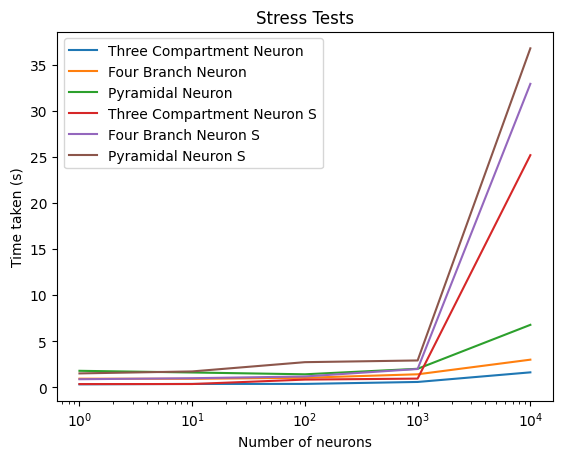

In [3]:
import datetime
total_time = 1
dt = 0.001
num_neurons_tests = (1, 10, 100, 1000, 10000)

model_tag = None
    
num_steps = (int)(total_time // dt)

base_weight = 2e-7

def transfer_layer(num_neurons, with_synapse):
    return BSSNeuronProcessTriangleSpike(name='TransferLayer', dt=dt, shape=(num_neurons,),
                            synapse_weights = [
                                [base_weight if j == i - 1 else 0 for j in range(num_neurons)]
                                for i in range(num_neurons)
                            ] if with_synapse else 0, # this weight matrix shifts right, i.e. a spike from neuron 1 passes to neuron 2, etc
                            starts = 0.1,
                            heights = [8e-9 if i == 0 else 0 for i in range(num_neurons)], 
                            uptimes = 0.05,
                            downtimes = 0.05)

results = []
legend = []

for num_neurons in num_neurons_tests:
    new_results = []
    print(f'Beginning tests with {num_neurons} neurons.\n')
    for with_synapse in (False, True):
        three_compartment_neuron = ThreeCompartmentNeuron(dt=dt, num_neurons=num_neurons, calcium_layer=transfer_layer(num_neurons, with_synapse))
        four_branch_neuron = SingleCompartmentFourBranchNeuron(dt=dt, num_neurons=num_neurons, top_left_layer=transfer_layer(num_neurons, with_synapse))
        pyramidal_neuron = SingleCompartmentPyramidalNeuron(dt=dt, num_neurons=num_neurons, top_nmda=transfer_layer(num_neurons, with_synapse))
        if with_synapse:
            three_compartment_neuron.sodium_layer.spike_out.connect(three_compartment_neuron.calcium_layer.synapse_in) # hook up the synapses
            four_branch_neuron.sodium_layer.spike_out.connect(four_branch_neuron.top_left_layer.synapse_in)
            pyramidal_neuron.sodium_layer.spike_out.connect(pyramidal_neuron.top_nmda.synapse_in)
        
        run_cfg = Loihi1SimCfg(select_tag=model_tag)

        for neuron, name in ((three_compartment_neuron, 'Three Compartment Neuron'),
                             (four_branch_neuron, 'Four Branch Neuron'),
                             (pyramidal_neuron, 'Pyramidal Neuron')):
            print(f'Now running {name} with {num_neurons} neurons and {"with" if with_synapse else "without"} synapse...')
            timestamp = datetime.datetime.now()
            neuron.sodium_layer.run(condition=RunSteps(num_steps=num_steps), run_cfg=run_cfg)
            neuron.sodium_layer.stop()
            final_time = datetime.datetime.now()
            delta = final_time - timestamp
            print(f'Took {delta}')

            testname = f'{name} {"S" if with_synapse else ""}'
            if testname not in legend:
                legend.append(testname)
            new_results.append(delta.seconds + delta.microseconds/1e6)
        print()
    results.append(new_results)
print(results)
plt.plot(num_neurons_tests, results)
plt.xlabel('Number of neurons')  
plt.ylabel('Time taken (s)')  
plt.xscale('log')
plt.title('Stress Tests')
plt.legend(legend)
plt.show()  

## Larger Scaling - Splitting Layers

This approach splits neurons into layers, where each layer connects via synapse to only the next one (and not back to itself). The idea here is that instead of using a single matrix with mmnn entries for a network of n layers with m neurons each, we can use n matrices with mm entries each, reducing the total number of entries by a factor of n. In this experiment, there are 10 layers with 10 pyramidal neurons each. It takes an unreasonable amount of time to run for such a small network, and it looks like Lava has trouble handling a couple hundred processes (remember that each pyramidal neuron is 17 processes) since sometimes it complains about too many open files. So it looks like splitting into layers is not the way to go, and using giant matrices is much more efficient.

Ran in 0:01:01.070214


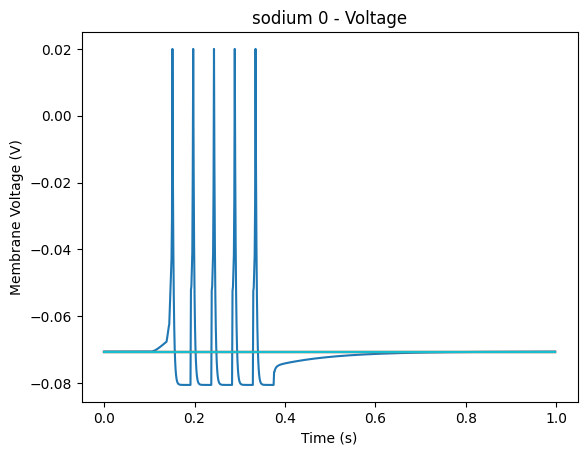

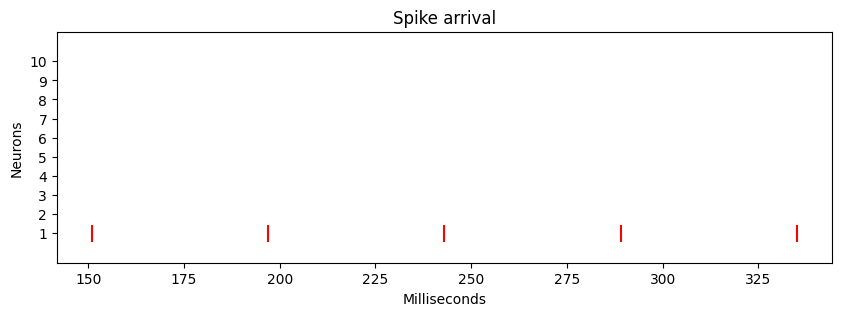

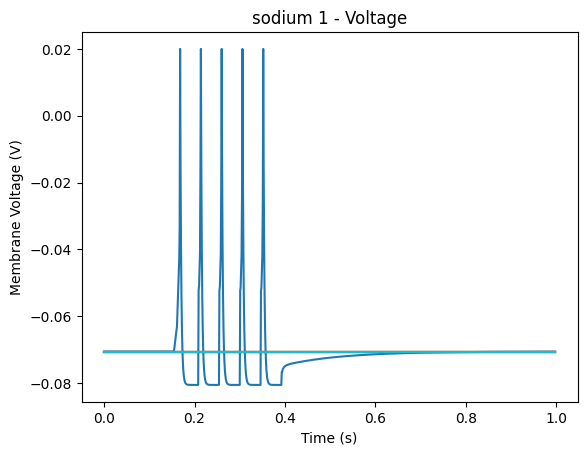

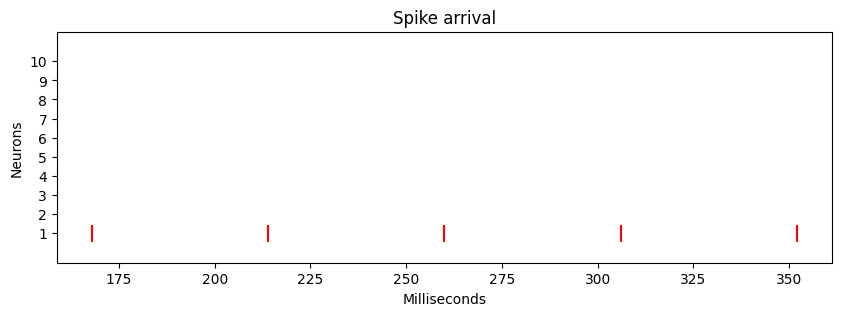

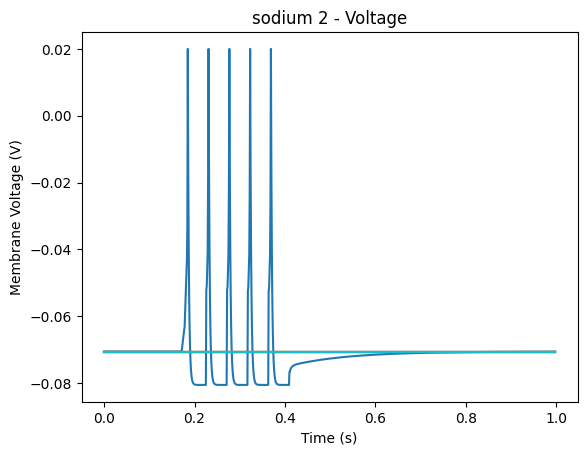

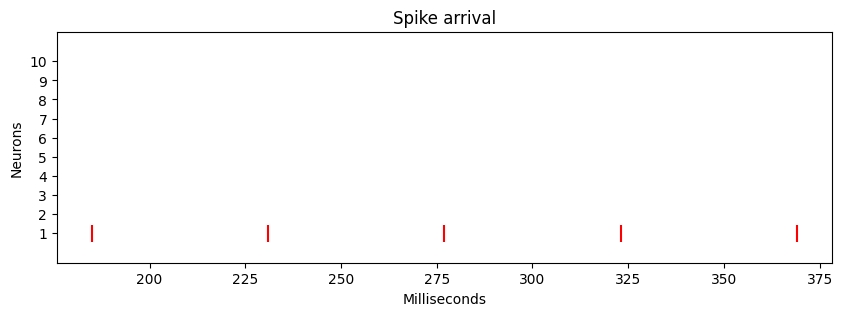

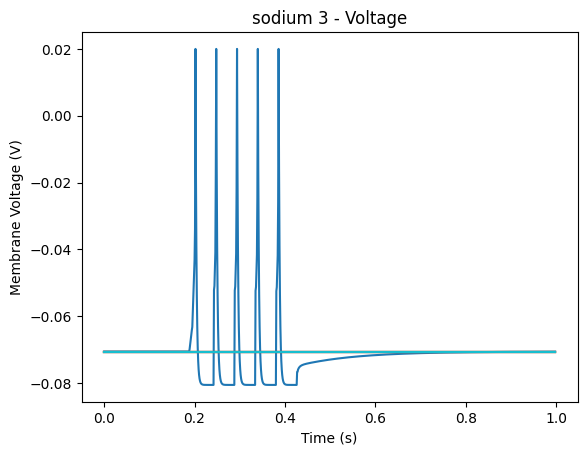

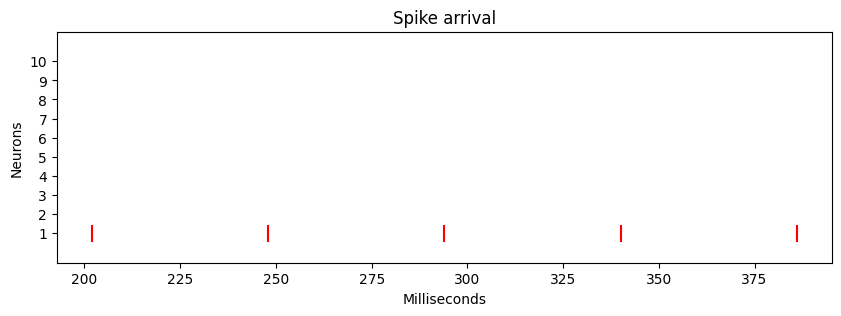

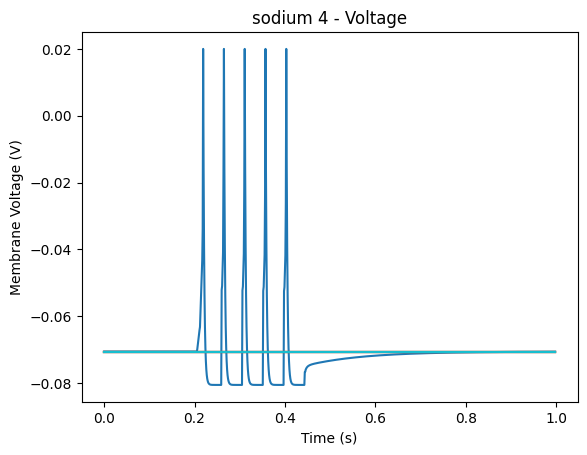

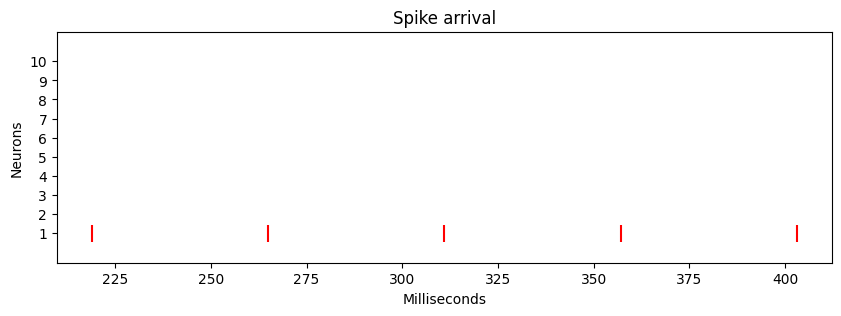

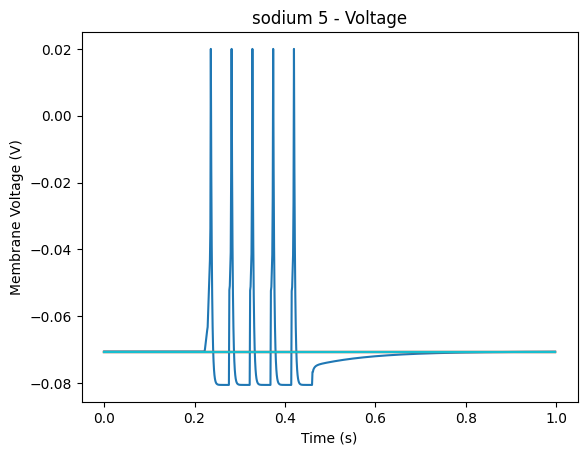

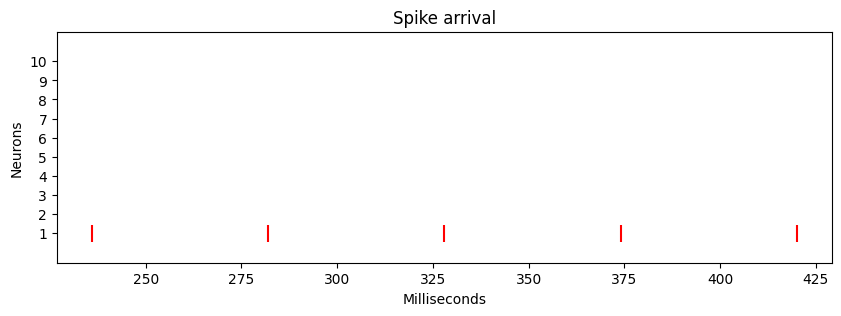

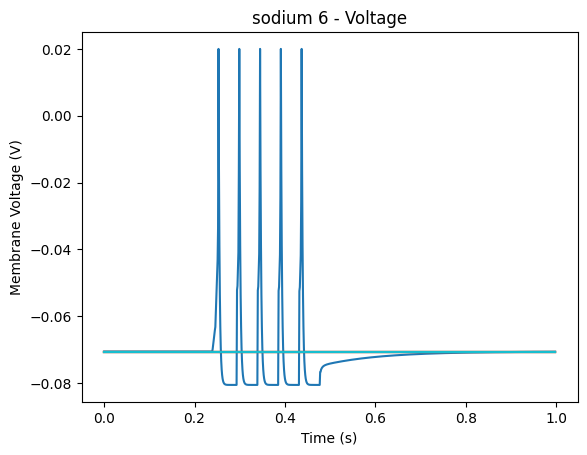

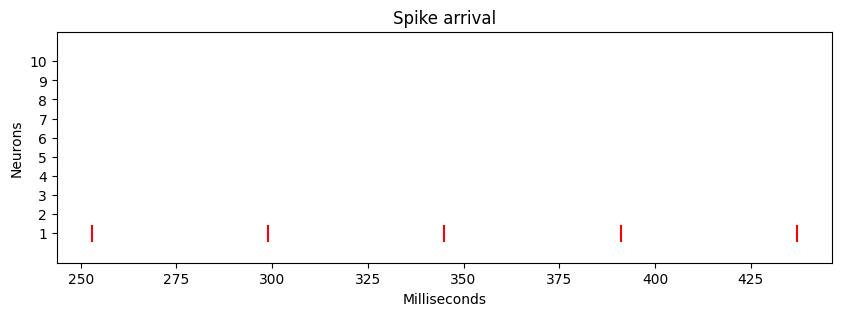

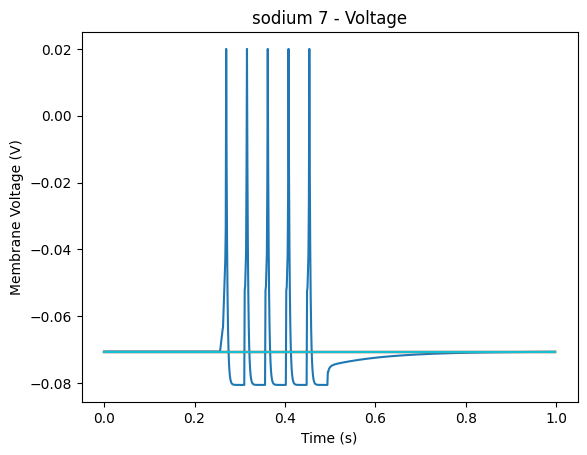

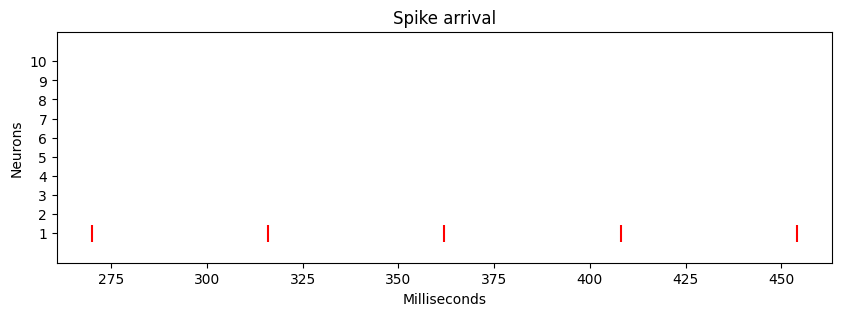

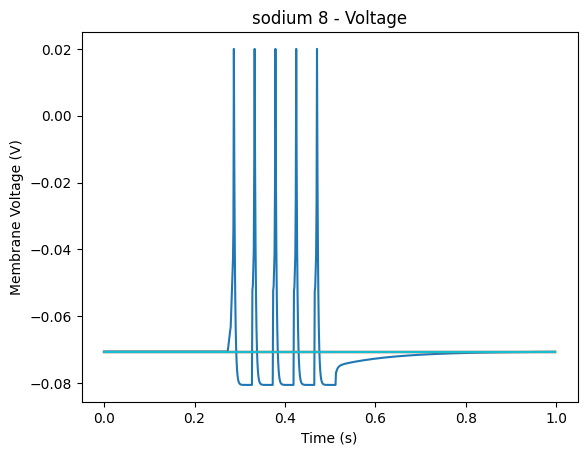

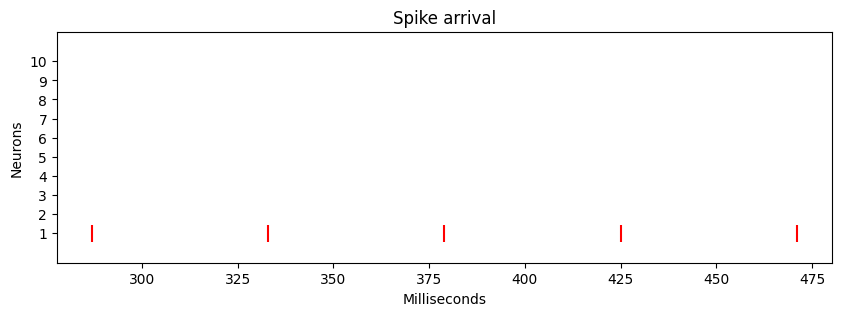

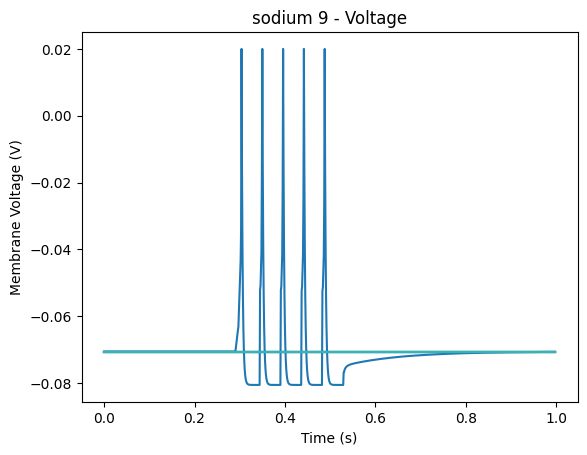

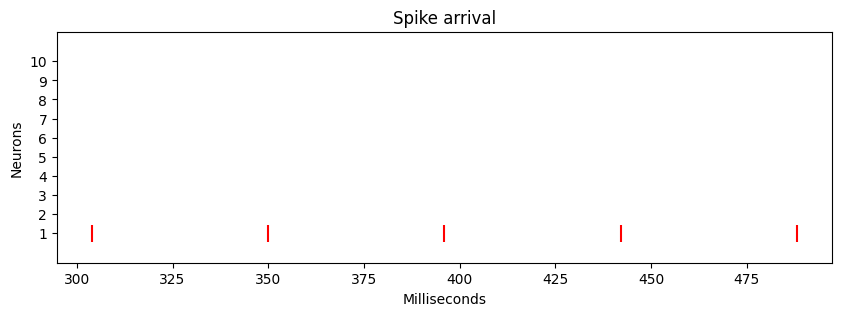

In [2]:
import datetime
total_time = 1
dt = 0.001
num_layers = 10
neurons_per_layer = 10

model_tag = None
    
num_steps = (int)(total_time // dt)

base_weight = 2e-7

def transfer_layer(layer_num):
    if layer_num == 0:
        return BSSNeuronProcessTriangleSpike(name='InitiationLayer', dt=dt, shape=(neurons_per_layer,),
                            synapse_weights = [
                                [base_weight if j == i else 0 for j in range(neurons_per_layer)]
                                for i in range(neurons_per_layer)
                            ], # this weight matrix shifts right, i.e. a spike from neuron 1 passes to neuron 2, etc
                            starts = 0.1,
                            heights = [8e-9 if i == 0 else 0 for i in range(neurons_per_layer)], 
                            uptimes = 0.05,
                            downtimes = 0.05)
    return BSSNeuronProcess(name=f'TransferLayer-{layer_num}', dt=dt, shape=(neurons_per_layer,), synapse_weights = [
                                [base_weight if j == i else 0 for j in range(neurons_per_layer)]
                                for i in range(neurons_per_layer)
                            ])

neurons = []
monitors = []
for n in range(num_layers):
    neuron = SingleCompartmentPyramidalNeuron(dt=dt, num_neurons=neurons_per_layer, top_nmda=transfer_layer(n), id=n)
    if n > 0:
        neurons[-1].sodium_layer.spike_out.connect(neuron.top_nmda.synapse_in)
    neurons.append(neuron)
    monitors.append(StandardNeuronMonitors(neuron.sodium_layer, num_steps))

run_cfg = Loihi1SimCfg(select_tag=model_tag)
timestamp = datetime.datetime.now()
neurons[0].sodium_layer.run(condition=RunSteps(num_steps=num_steps), run_cfg=run_cfg)

final_time = datetime.datetime.now()
print(f'Ran in {final_time - timestamp}')
for n in range(num_layers):
    sodium_voltage_data = monitors[n].V_m_monitor.get_neuron_data()
    plot_voltage(f'sodium {n}', [i * dt for i in range(num_steps)], 
                             sodium_voltage_data)
    plot_spikes(spikes=[np.where(monitors[n].spike_monitor.get_neuron_data()[:, i])[0] for i in range(neurons_per_layer)], 
                legend=[f'{i + 1}' for i in range(neurons_per_layer)], 
                colors=['#ff0000' for i in range(neurons_per_layer)])
    
neurons[0].sodium_layer.stop()